### Purpose of Notebook: build model to predict whether or not a premier league match will have a score greater than 2 (or 2.5 as the bettings firms classify the cutoff point)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson,skellam
from pandas.plotting import scatter_matrix
#from astropy.stats import boostrap
%matplotlib inline
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_info_columns', 150)
pd.set_option('display.max_info_rows', 150)
plt.style.use('seaborn')

In [3]:
# pull data and explore
df = pd.read_csv("season-1819.csv")
df2 = pd.read_csv("season-1718.csv")

# create total score field, which will need for binary label
df['total_score'] = (df.FTHG + df.FTAG)
df2['total_score'] = (df2.FTHG + df2.FTAG)

# get overview of dataframes
print('18-19 df info and head:\n')
df.info()
df.head()
df.describe()

print('\n18-19 df info and head:\n')
df2.info()
df2.head()
df2.describe()

18-19 df info and head:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 23 columns):
Date           object
HomeTeam       object
AwayTeam       object
FTHG           int64
FTAG           int64
FTR            object
HTHG           int64
HTAG           int64
HTR            object
Referee        object
HS             int64
AS             int64
HST            int64
AST            int64
HF             int64
AF             int64
HC             int64
AC             int64
HY             int64
AY             int64
HR             int64
AR             int64
total_score    int64
dtypes: int64(17), object(6)
memory usage: 48.4+ KB


Date      HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  2018-08-10    Man United       Leicester     2     1   H     1     0   H   
1  2018-08-11   Bournemouth         Cardiff     2     0   H     1     0   H   
2  2018-08-11        Fulham  Crystal Palace     0     2   A     0     1   A   
3  2018-08-11  Huddersfield         Chelsea     0     3   A     0     2   A   
4  2018-08-11     Newcastle       Tottenham     1     2   A     1     2   A   

      Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  
0  A Marriner   8  13    6    4  11   8   2   5   2   1   0   0            3  
1    K Friend  12  10    4    1  11   9   7   4   1   1   0   0            2  
2      M Dean  15  10    6    9   9  11   5   5   1   2   0   0            2  
3  C Kavanagh   6  13    1    4   9   8   2   5   2   1   0   0            3  
4  M Atkinson  15  15    2    5  11  12   3   5   2   2   0   0            3

FTHG        FTAG        HTHG        HTAG          HS          AS  \
count  269.000000  269.000000  269.000000  269.000000  269.000000  269.000000   
mean     1.553903    1.278810    0.695167    0.594796   14.178439   10.899628   
std      1.338952    1.165565    0.883099    0.793708    5.962393    4.248920   
min      0.000000    0.000000    0.000000    0.000000    2.000000    2.000000   
25%      1.000000    0.000000    0.000000    0.000000   10.000000    8.000000   
50%      1.000000    1.000000    0.000000    0.000000   14.000000   10.000000   
75%      2.000000    2.000000    1.000000    1.000000   17.000000   13.000000   
max      6.000000    6.000000    4.000000    3.000000   36.000000   25.000000   

              HST         AST          HF          AF          HC          AC  \
count  269.000000  269.000000  269.000000  269.000000  269.000000  269.000000   
mean     4.884758    3.977695   10.568773   10.427509    5.732342    4.513011   
std      2.699798    2.267442    3.198634    3.607536    2.906971    2.736708   
min      0.000000    0.000000    3.000000    3.000000    1.000000    0.000000   
25%      3.000000    2.000000    8.000000    8.000000    4.000000    2.000000   
50%      5.000000    4.000000   10.000000   10.000000    5.000000    4.000000   
75%      6.000000    6.000000   13.000000   13.000000    8.000000    6.000000   
max     14.000000   12.000000   23.000000   21.000000   14.000000   13.000000   

               HY          AY          HR          AR  total_score  
count  269.000000  269.000000  269.000000  269.000000   269.000000  
mean     1.542751    1.713755    0.055762    0.085502     2.832714  
std      1.219797    1.238317    0.229889    0.280148     1.615540  
min      0.000000    0.000000    0.000000    0.000000     0.000000  
25%      1.000000    1.000000    0.000000    0.000000     2.000000  
50%      1.000000    2.000000    0.000000    0.000000     3.000000  
75%      2.000000    2.000000    0.000000    0.000000     4.000000  
max      6.000000    5.000000    1.000000    1.000000     8.000000


18-19 df info and head:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 23 columns):
Date           object
HomeTeam       object
AwayTeam       object
FTHG           int64
FTAG           int64
FTR            object
HTHG           int64
HTAG           int64
HTR            object
Referee        object
HS             int64
AS             int64
HST            int64
AST            int64
HF             int64
AF             int64
HC             int64
AC             int64
HY             int64
AY             int64
HR             int64
AR             int64
total_score    int64
dtypes: int64(17), object(6)
memory usage: 68.4+ KB


Date        HomeTeam      AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  2017-08-11         Arsenal     Leicester     4     3   H     2     2   D   
1  2017-08-12        Brighton      Man City     0     2   A     0     0   D   
2  2017-08-12         Chelsea       Burnley     2     3   A     0     3   A   
3  2017-08-12  Crystal Palace  Huddersfield     0     3   A     0     2   A   
4  2017-08-12         Everton         Stoke     1     0   H     1     0   H   

       Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  
0       M Dean  27   6   10    3   9  12   9   4   0   1   0   0            7  
1     M Oliver   6  14    2    4   6   9   3  10   0   2   0   0            2  
2     C Pawson  19  10    6    5  16  11   8   5   3   3   2   0            5  
3       J Moss  14   8    4    6   7  19  12   9   1   3   0   0            3  
4  N Swarbrick   9   9    4    1  13  10   6   7   1   1   0   0            1

FTHG        FTAG        HTHG        HTAG          HS          AS  \
count  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000   
mean     1.531579    1.147368    0.607895    0.515789   13.584211   10.855263   
std      1.340087    1.177793    0.793403    0.756511    5.771439    4.858700   
min      0.000000    0.000000    0.000000    0.000000    2.000000    0.000000   
25%      1.000000    0.000000    0.000000    0.000000    9.000000    7.000000   
50%      1.000000    1.000000    0.000000    0.000000   13.000000   10.500000   
75%      2.000000    2.000000    1.000000    1.000000   17.000000   14.000000   
max      7.000000    6.000000    4.000000    3.000000   35.000000   30.000000   

              HST         AST          HF          AF          HC          AC  \
count  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000   
mean     4.626316    3.763158   10.218421   10.478947    5.739474    4.544737   
std      2.706845    2.317015    3.256360    3.336388    2.993047    2.767241   
min      0.000000    0.000000    2.000000    3.000000    0.000000    0.000000   
25%      3.000000    2.000000    8.000000    8.000000    4.000000    2.000000   
50%      4.000000    3.500000   10.000000   10.000000    5.000000    4.000000   
75%      6.000000    5.000000   12.000000   13.000000    8.000000    6.000000   
max     15.000000   14.000000   19.000000   26.000000   18.000000   13.000000   

               HY          AY          HR          AR  total_score  
count  380.000000  380.000000  380.000000  380.000000   380.000000  
mean     1.478947    1.565789    0.044737    0.057895     2.678947  
std      1.256993    1.259639    0.219375    0.233852     1.665125  
min      0.000000    0.000000    0.000000    0.000000     0.000000  
25%      1.000000    1.000000    0.000000    0.000000     1.000000  
50%      1.000000    1.000000    0.000000    0.000000     3.000000  
75%      2.000000    2.000000    0.000000    0.000000     4.000000  
max      6.000000    7.000000    2.000000    1.000000     9.000000

### ^^ Great, we don't have to worry about missing data.

# first look at goal distribution

In [4]:
# creating hist plotting function, 
# overlay with poisson pmf, common distribution for sports goals
def hagoal_plot(df=df, title='#Goals/Match', 
                bin_field=['FTHG','FTAG'], 
                hist_label=['Home', 'Away'], 
                set_alpha=0.5,
                goal_max=10):
    """function to create the home/away goal histogram with poisson pmf overlay"""
    
    pos_pred = np.column_stack([[poisson.pmf(i, df[bin_field].mean()[j]) for i in range(goal_max)] 
                                    for j in range(len(bin_field))])

    # poisson pmf lines
    if len(bin_field) == 2:
        plt.hist(df[bin_field].values, range(10), 
                  alpha=set_alpha, label=hist_label,
                  density=True, color=['r', 'b'])
        _pois_1 = plt.plot([i-0.5 for i in range(1,goal_max+1)], pos_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = 'r')
        _pois2, = plt.plot([i-0.5 for i in range(1,goal_max+1)], pos_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = 'b')
    else:
        plt.hist(df[bin_field].values, range(10), 
                 alpha=set_alpha, label=hist_label,density=True, color=['r'])
        _pois_1 = plt.plot([i-0.5 for i in range(1,goal_max+1)], pos_pred[:,0],
                  linestyle='-', marker='o',label="Total Score", color = 'r')

    plt.xticks([i-0.5 for i in range(1,goal_max+1)],[i for i in range(10)])
    leg=plt.legend(loc='upper right', fontsize=15, ncol=2)
    leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})
    plt.xlabel("#Goals/Match",size=13)
    plt.ylabel("% of Matches",size=13)
    plt.title(title, size=14, fontweight='bold')
    plt.ylim([-0.004, 0.4])
    plt.tight_layout()
    plt.show() 

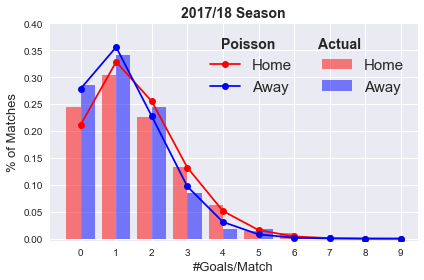

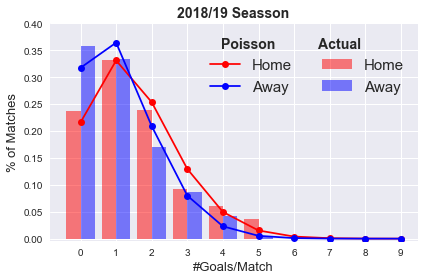

In [5]:
# run goal plotting function on 2017/18 and 2017/18 seasons and combined
hagoal_plot(df=df, title='2017/18 Season')
hagoal_plot(df=df2, title='2018/19 Seasson')

### ^^^ Looks like home/away goals hist follow quite closely to their relative poisson pmfs

In [6]:
# create total score field, which will be label/y value of model
df_total = pd.concat([df, df2], ignore_index=True)
print('18-19 df info and head:\n')
df_total.info()
df_total.head()

18-19 df info and head:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 23 columns):
Date           object
HomeTeam       object
AwayTeam       object
FTHG           int64
FTAG           int64
FTR            object
HTHG           int64
HTAG           int64
HTR            object
Referee        object
HS             int64
AS             int64
HST            int64
AST            int64
HF             int64
AF             int64
HC             int64
AC             int64
HY             int64
AY             int64
HR             int64
AR             int64
total_score    int64
dtypes: int64(17), object(6)
memory usage: 116.7+ KB


Date      HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  2018-08-10    Man United       Leicester     2     1   H     1     0   H   
1  2018-08-11   Bournemouth         Cardiff     2     0   H     1     0   H   
2  2018-08-11        Fulham  Crystal Palace     0     2   A     0     1   A   
3  2018-08-11  Huddersfield         Chelsea     0     3   A     0     2   A   
4  2018-08-11     Newcastle       Tottenham     1     2   A     1     2   A   

      Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  
0  A Marriner   8  13    6    4  11   8   2   5   2   1   0   0            3  
1    K Friend  12  10    4    1  11   9   7   4   1   1   0   0            2  
2      M Dean  15  10    6    9   9  11   5   5   1   2   0   0            2  
3  C Kavanagh   6  13    1    4   9   8   2   5   2   1   0   0            3  
4  M Atkinson  15  15    2    5  11  12   3   5   2   2   0   0            3

In [7]:
# now lets look at the mean of the home/away goals
df[['FTHG','FTAG']].mean()
df2[['FTHG','FTAG']].mean()
df_total[['FTHG','FTAG']].mean()

# now look at variance
np.var(df[['FTHG','FTAG']])
np.var(df2[['FTHG','FTAG']])
np.var(df_total[['FTHG','FTAG']])

# for reference in poisson distribution the
# expected value = variance

FTHG    1.553903
FTAG    1.278810
dtype: float64

FTHG    1.531579
FTAG    1.147368
dtype: float64

FTHG    1.540832
FTAG    1.201849
dtype: float64

FTHG    1.786128
FTAG    1.353492
dtype: float64

FTHG    1.791108
FTAG    1.383546
dtype: float64

FTHG    1.789165
FTAG    1.375282
dtype: float64

#### ^^ the variance looks pretty close to its mean counterpart so it appears that this is from a poisson distibution. 

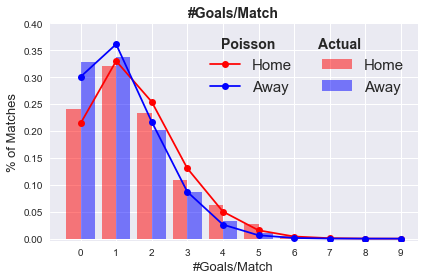

In [8]:
hagoal_plot(df=df_total)

### ^^^ both seasons combined also follows closely to the poisson

## Now lets do the same plotting exercise but for total goals 

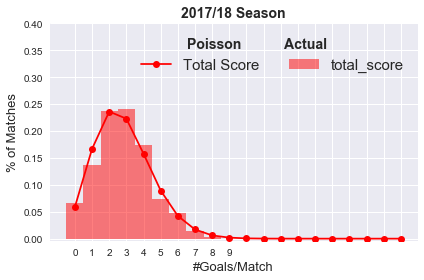

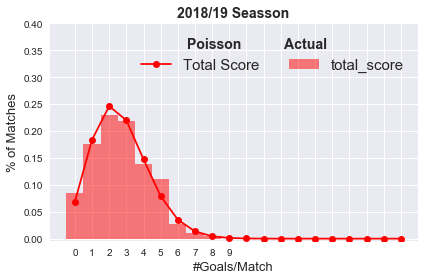

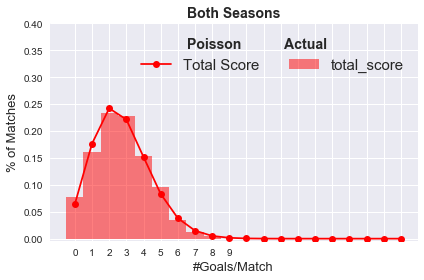

In [9]:
hagoal_plot(df=df, title='2017/18 Season', 
            bin_field=['total_score'], 
            hist_label=['total_score'],
            goal_max = 20)
hagoal_plot(df=df2, title='2018/19 Seasson',
            bin_field=['total_score'],
            hist_label=['total_score'],
            goal_max = 20)
hagoal_plot(df=df_total, title='Both Seasons', 
            bin_field=['total_score'],
            hist_label=['total_score'],
            goal_max = 20)

In [10]:
df['total_score'].mean()
df2['total_score'].mean()
df_total['total_score'].mean()

2.83271375464684

2.6789473684210527

2.7426810477657937

In [11]:
# now lets look at the mean of the home/away goals
df['total_score'].mean()
df2['total_score'].mean()
df_total['total_score'].mean()

# now look at variance
np.var(df['total_score'])
np.var(df2['total_score'])
np.var(df_total['total_score'])

# for reference in poisson distribution the
# expected value = variance

2.83271375464684

2.6789473684210527

2.7426810477657937

2.600268100219732

2.7653462603878114

2.7026621494250964

#### ^^ the variance for total score also looks pretty close to its mean counterpart so it appears that this is from a poisson distibution. 

### now lets set up our binary y variable for classification/binary regression prep

### we are going to use the combined data of 2017 through the current 2018/19 season and use days/months from match date to current date as a field in our future classifier

In [12]:
# lets create some more variables; mostly totals of the home and away features 
df_total['y'] = df_total['total_score'].apply(lambda x: 1 if x > 2.5 else 0)
df_total['total_half_score'] = df_total.HTHG + df_total.HTAG
df_total['TS'] = df_total.HS + df_total.AS # TS = total shots
df_total['TST'] = df_total.HST + df_total.AST # TST = total shots on target
df_total['corners'] = df_total.HC + df_total.AC
df_total['yellows'] = df_total.HY + df_total.AY
df_total['reds'] = df_total.HR + df_total.AR
df_total['fouls'] = df_total.HF + df_total.AF

# remove FTR and HTR since we can get result info from scores
df_total = df_total.drop(columns=['FTR', 'HTR'])

df_total.info()
df_total.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 29 columns):
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
y                   int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
dtypes: int64(25), object(4)
memory usage: 147.1+ KB


Date      HomeTeam        AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  2018-08-10    Man United       Leicester     2     1     1     0   
1  2018-08-11   Bournemouth         Cardiff     2     0     1     0   
2  2018-08-11        Fulham  Crystal Palace     0     2     0     1   
3  2018-08-11  Huddersfield         Chelsea     0     3     0     2   
4  2018-08-11     Newcastle       Tottenham     1     2     1     2   
5  2018-08-11       Watford        Brighton     2     0     1     0   
6  2018-08-11        Wolves         Everton     2     2     1     1   
7  2018-08-12       Arsenal        Man City     0     2     0     1   
8  2018-08-12     Liverpool        West Ham     4     0     2     0   
9  2018-08-12   Southampton         Burnley     0     0     0     0   

      Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0  A Marriner   8  13    6    4  11   8   2   5   2   1   0   0            3   
1    K Friend  12  10    4    1  11   9   7   4   1   1   0   0            2   
2      M Dean  15  10    6    9   9  11   5   5   1   2   0   0            2   
3  C Kavanagh   6  13    1    4   9   8   2   5   2   1   0   0            3   
4  M Atkinson  15  15    2    5  11  12   3   5   2   2   0   0            3   
5      J Moss  19   6    5    0  10  16   8   2   2   2   0   0            2   
6    C Pawson  11   6    4    5   8   7   3   6   0   1   0   1            4   
7    M Oliver   9  17    3    8  11  14   2   9   2   2   0   0            2   
8    A Taylor  18   5    8    2  14   9   5   4   1   2   0   0            4   
9     G Scott  18  16    3    6  10   9   8   5   0   1   0   0            0   

   y  total_half_score  TS  TST  corners  yellows  reds  fouls  
0  1                 1  21   10        7        3     0     19  
1  0                 1  22    5       11        2     0     20  
2  0                 1  25   15       10        3     0     20  
3  1                 2  19    5        7        3     0     17  
4  1                 3  30    7        8        4     0     23  
5  0                 1  25    5       10        4     0     26  
6  1                 2  17    9        9        1     1     15  
7  0                 1  26   11       11        4     0     25  
8  1                 2  23   10        9        3     0     23  
9  0                 0  34    9       13        1     0     19

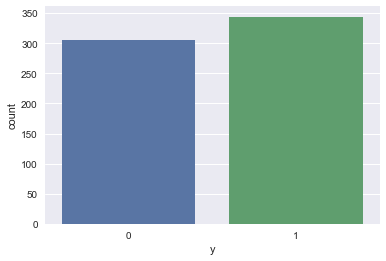

In [13]:
sns.countplot(x='y', data=df_total)
plt.show()

<Figure size 1800x720 with 0 Axes>

total score swarmplot by HomeTeam


<Figure size 1800x720 with 0 Axes>

total score swarmplot by AwayTeam


<Figure size 1800x720 with 0 Axes>

total score swarmplot by Referee


<Figure size 1800x720 with 0 Axes>

total score swarmplot by total_half_score


<Figure size 1800x720 with 0 Axes>

total score swarmplot by TS


<Figure size 1800x720 with 0 Axes>

total score swarmplot by TST


<Figure size 1800x720 with 0 Axes>

total score swarmplot by corners


<Figure size 1800x720 with 0 Axes>

total score swarmplot by yellows


<Figure size 1800x720 with 0 Axes>

total score swarmplot by reds


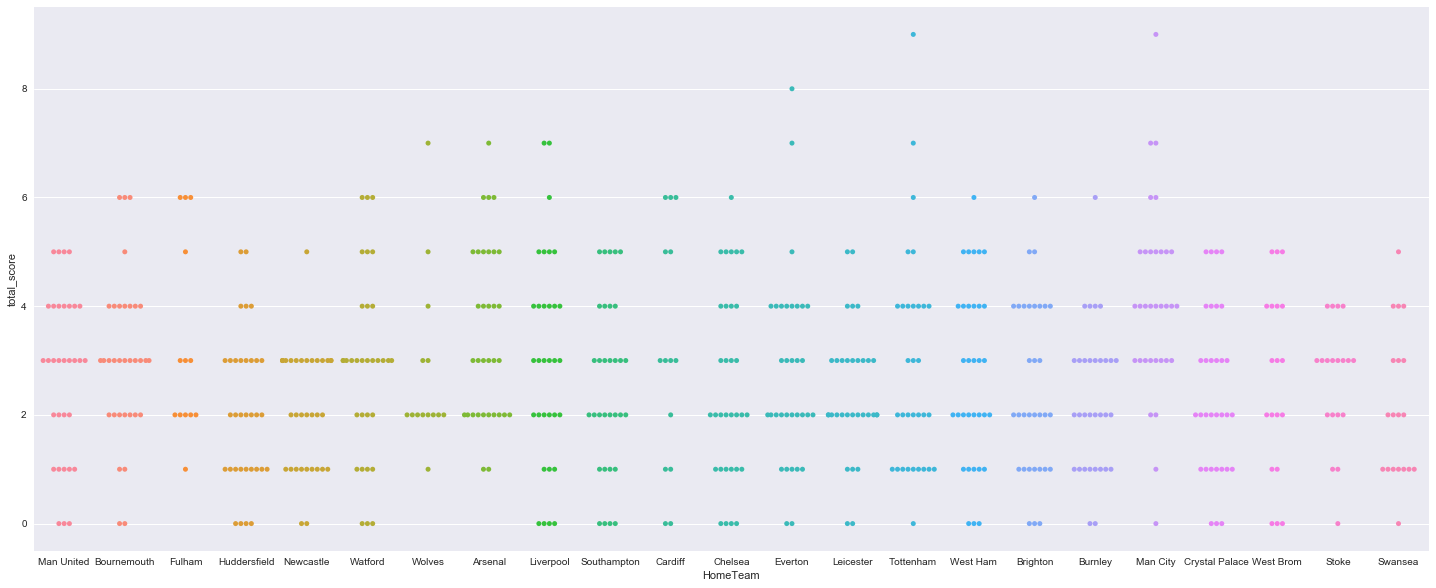

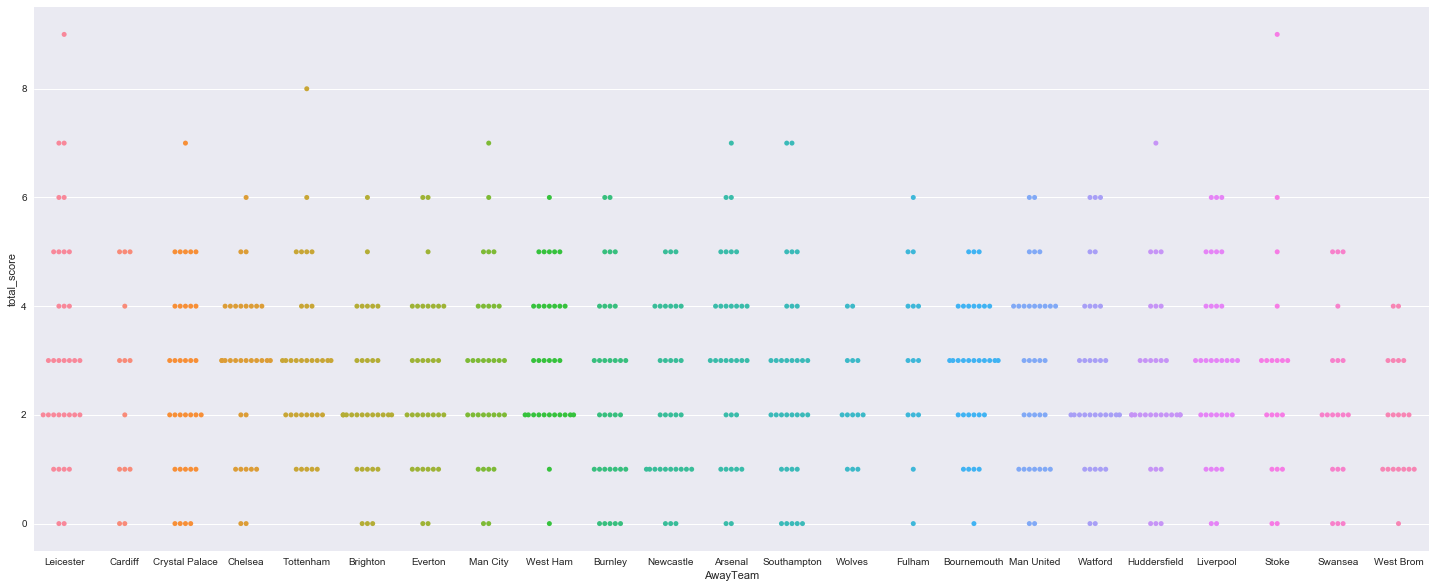

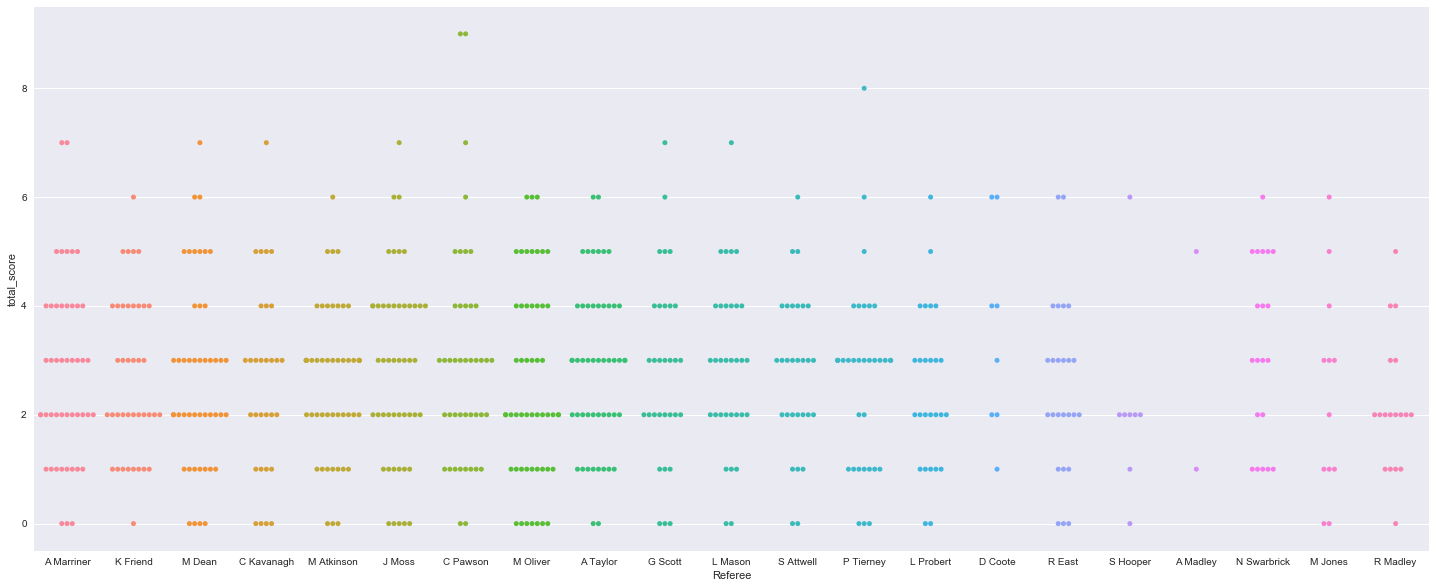

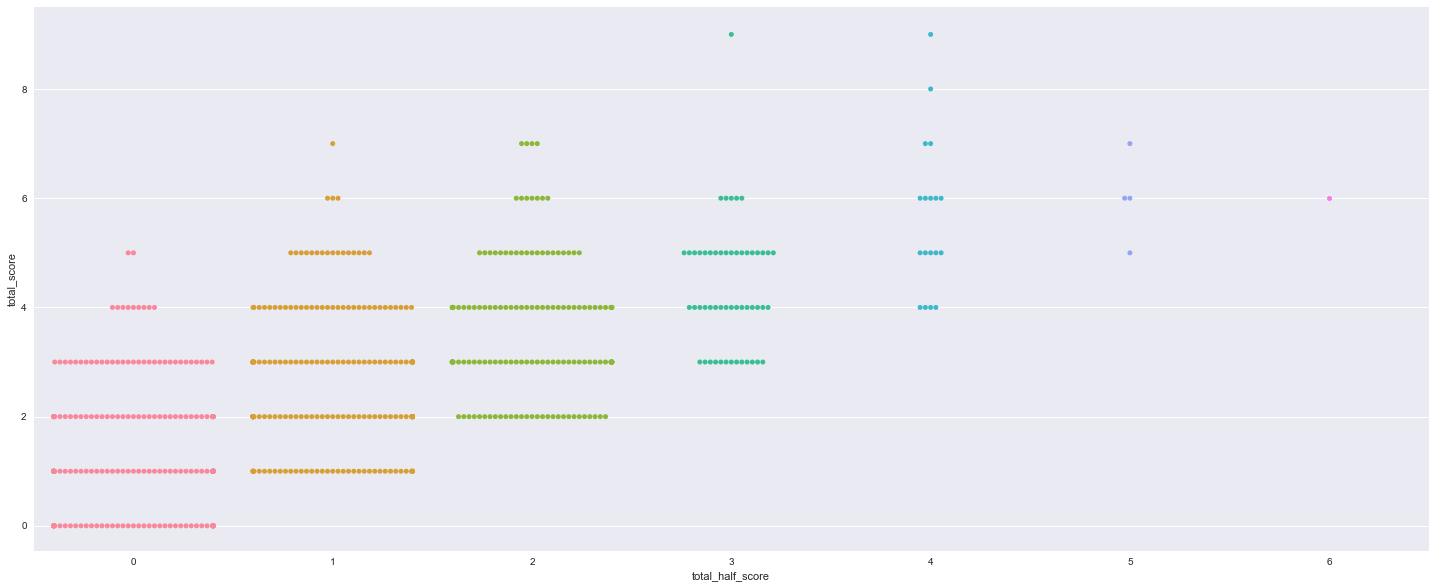

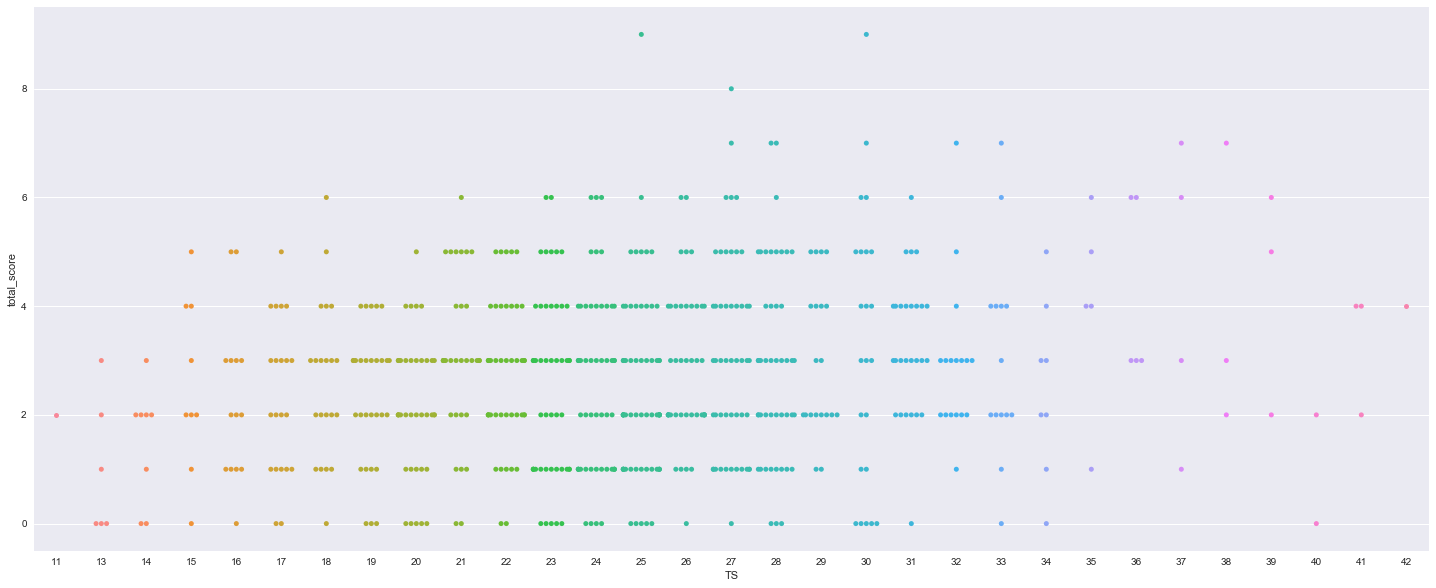

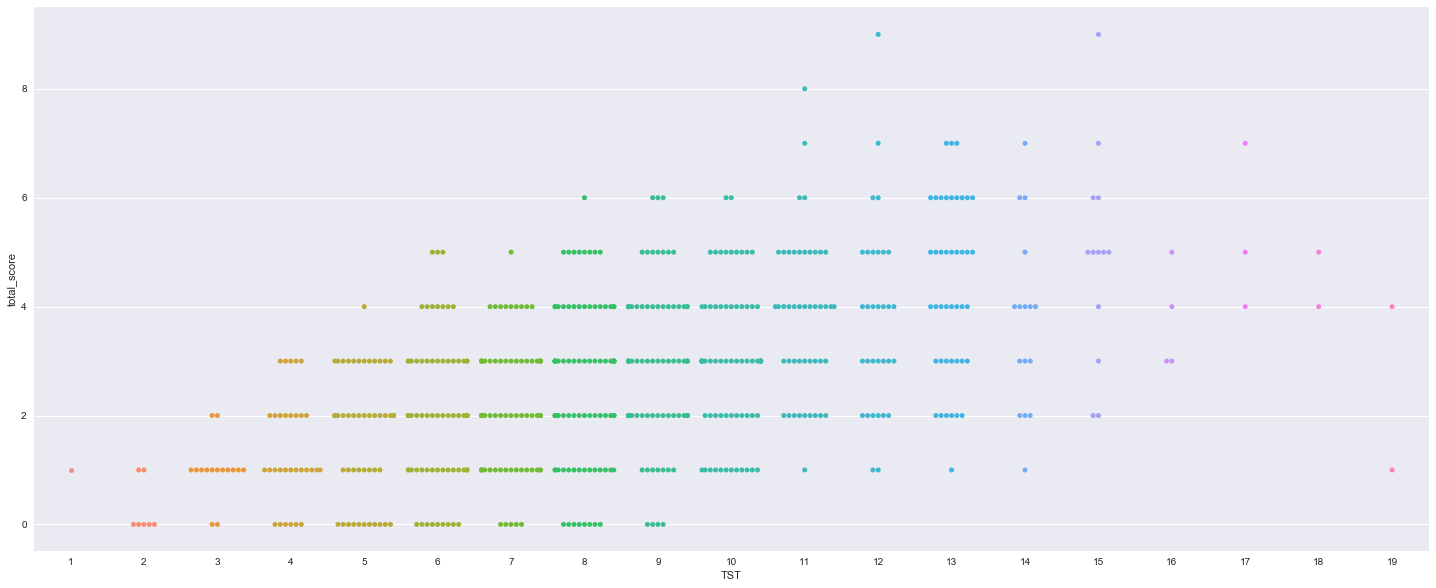

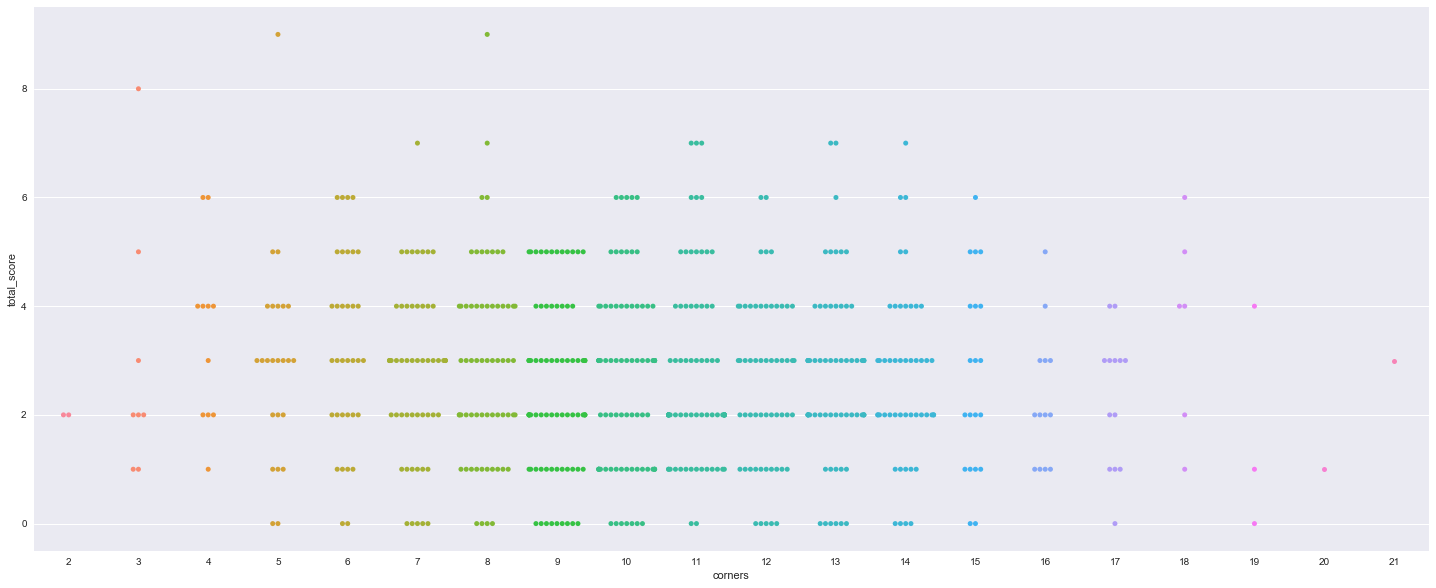

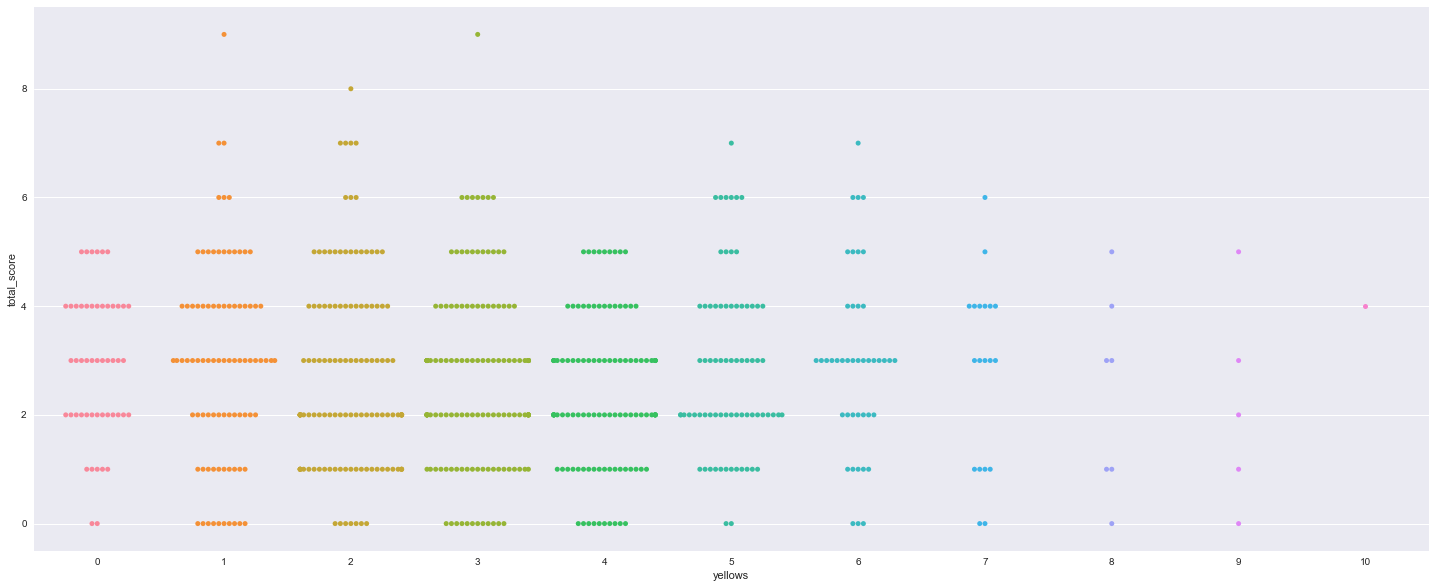

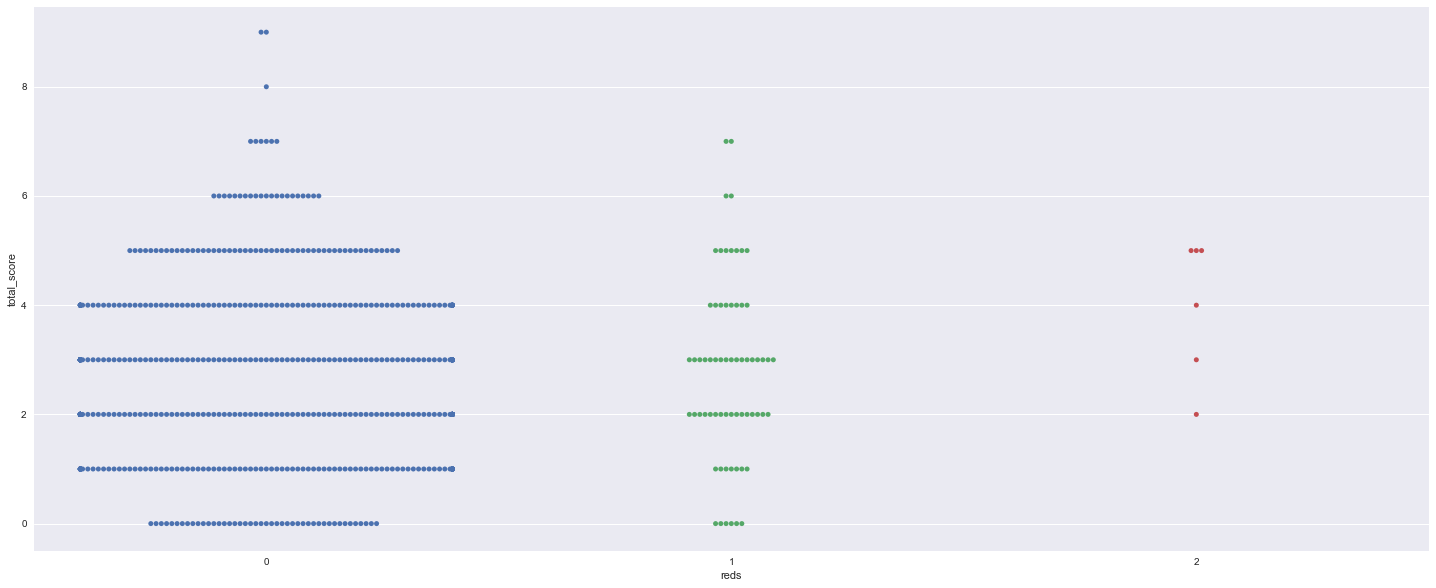

In [14]:
# now lets look at total score swarm plots by various features

swarm_list = ['HomeTeam', 'AwayTeam', 'Referee','total_half_score', 
              'TS', 'TST', 'corners', 'yellows', 'reds']

for x in swarm_list:
    plt.figure(figsize=(25,10))
    print('total score swarmplot by ' + x)
    sns.swarmplot(df_total[x], df_total.total_score)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

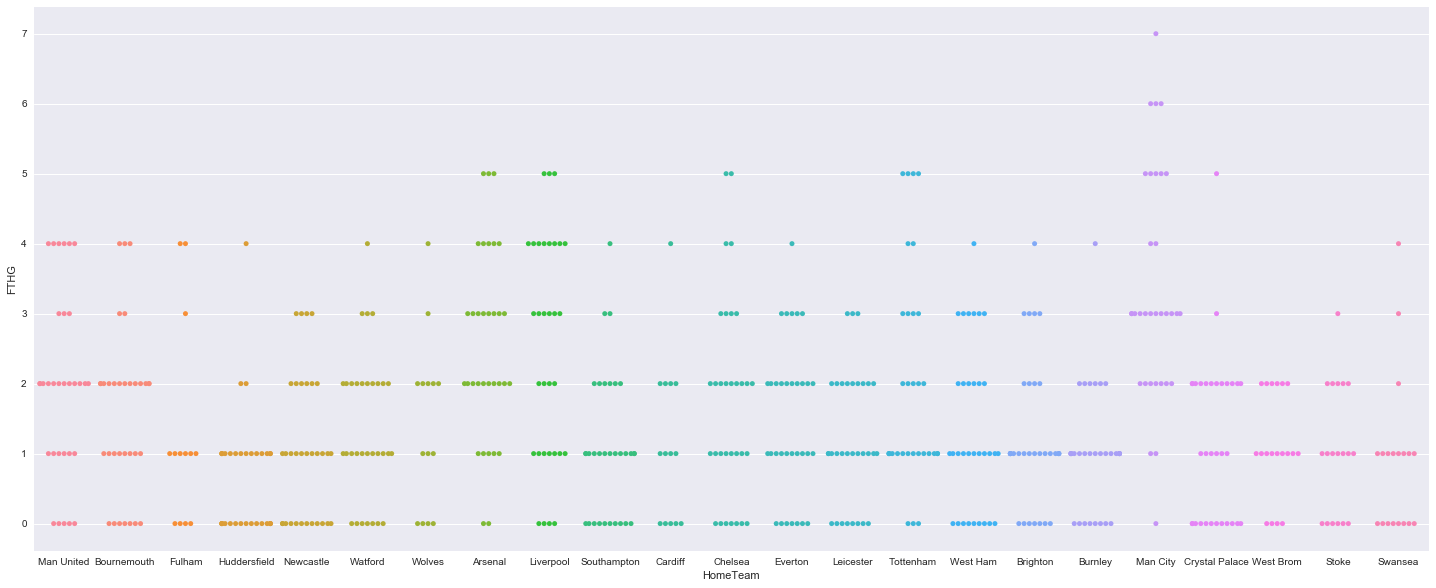

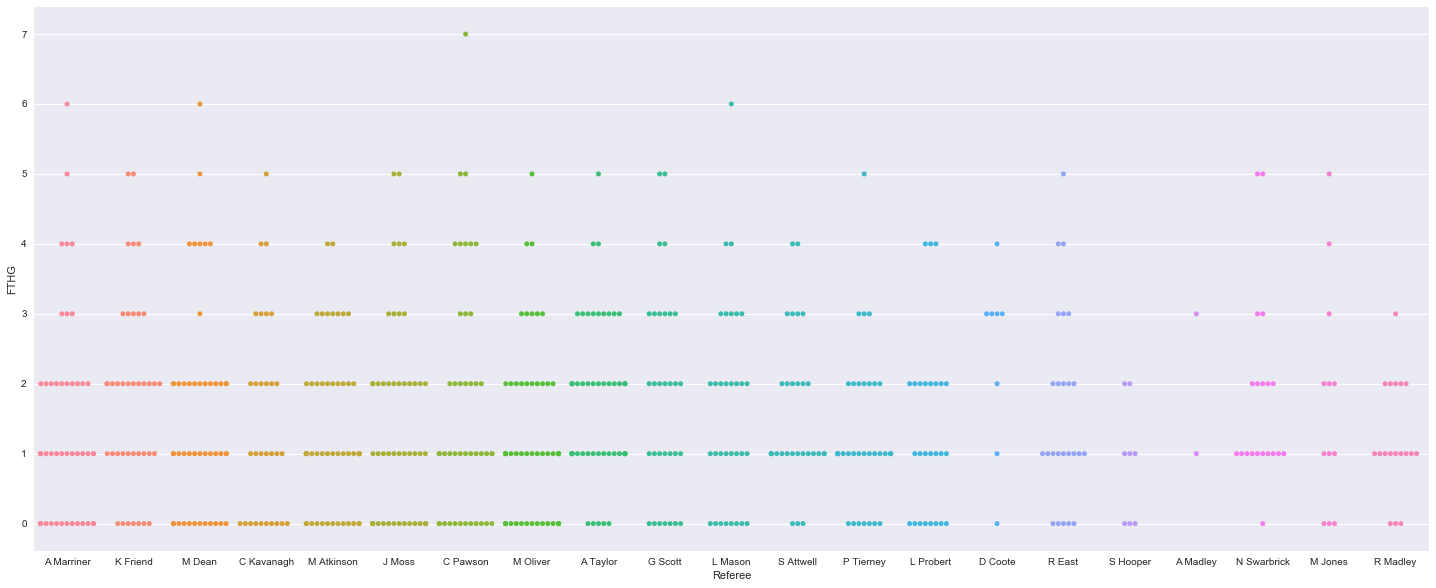

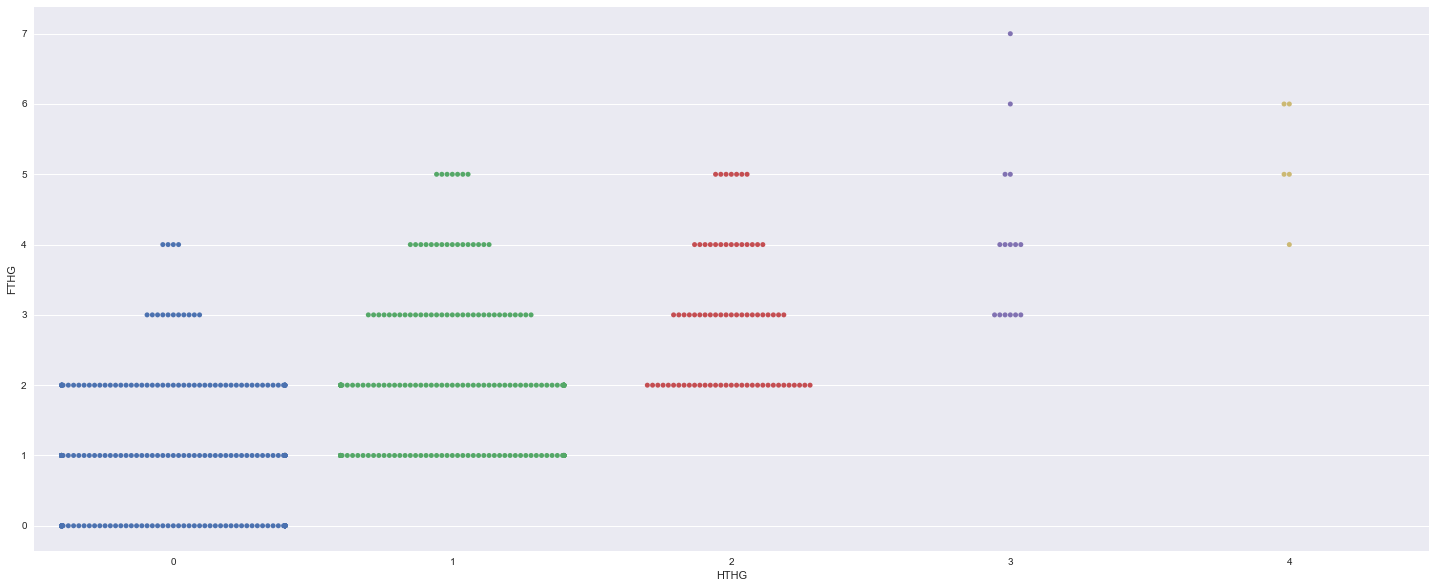

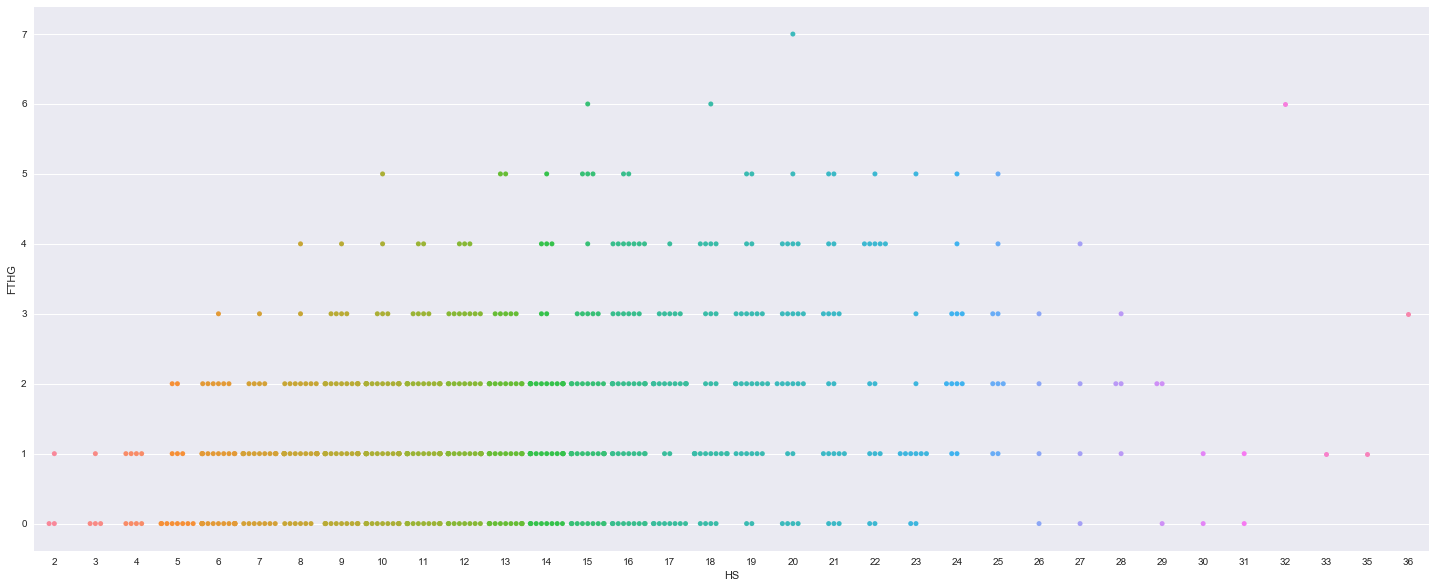

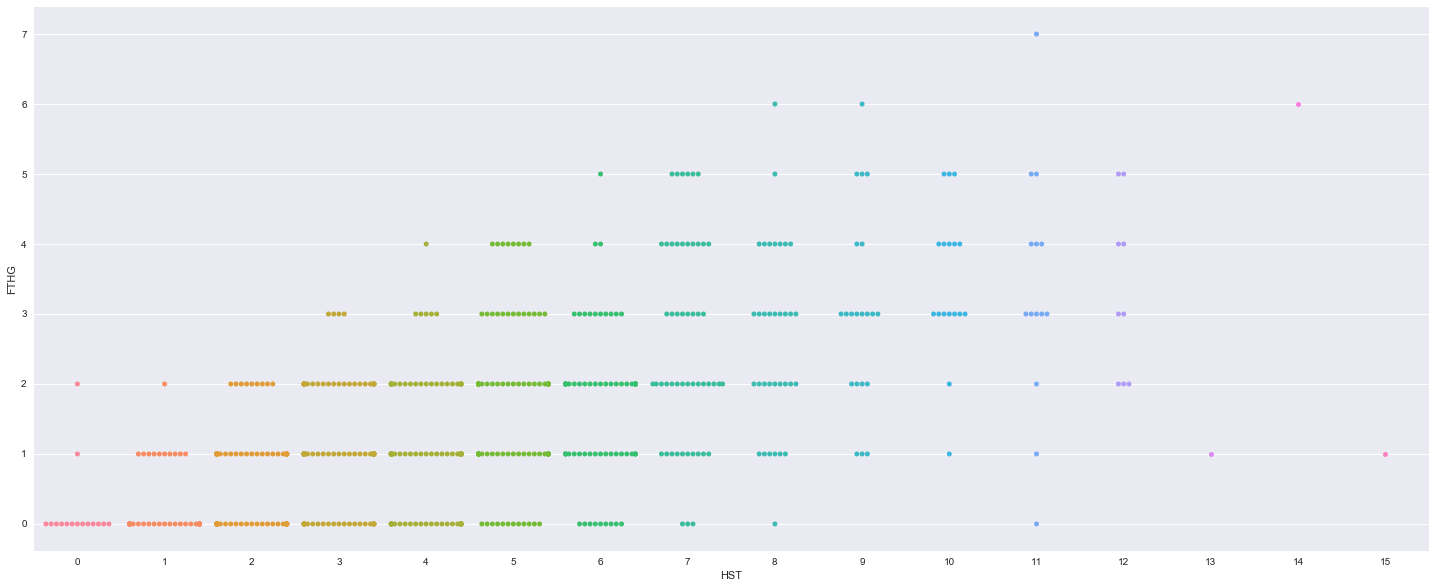

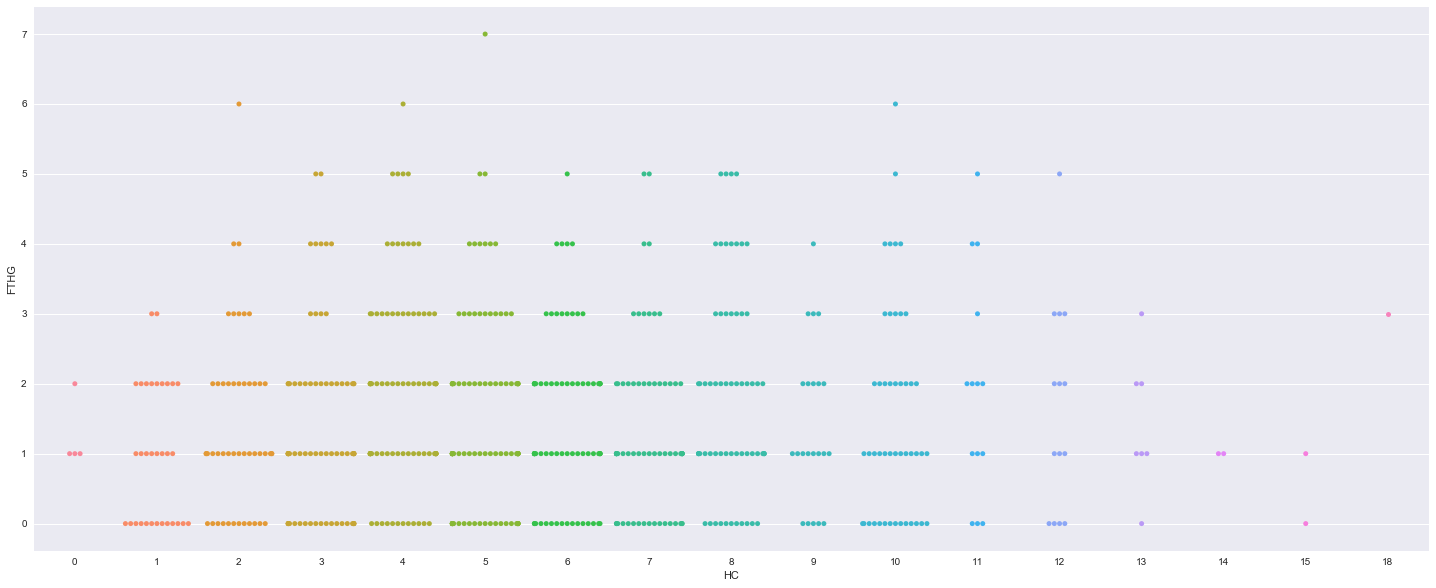

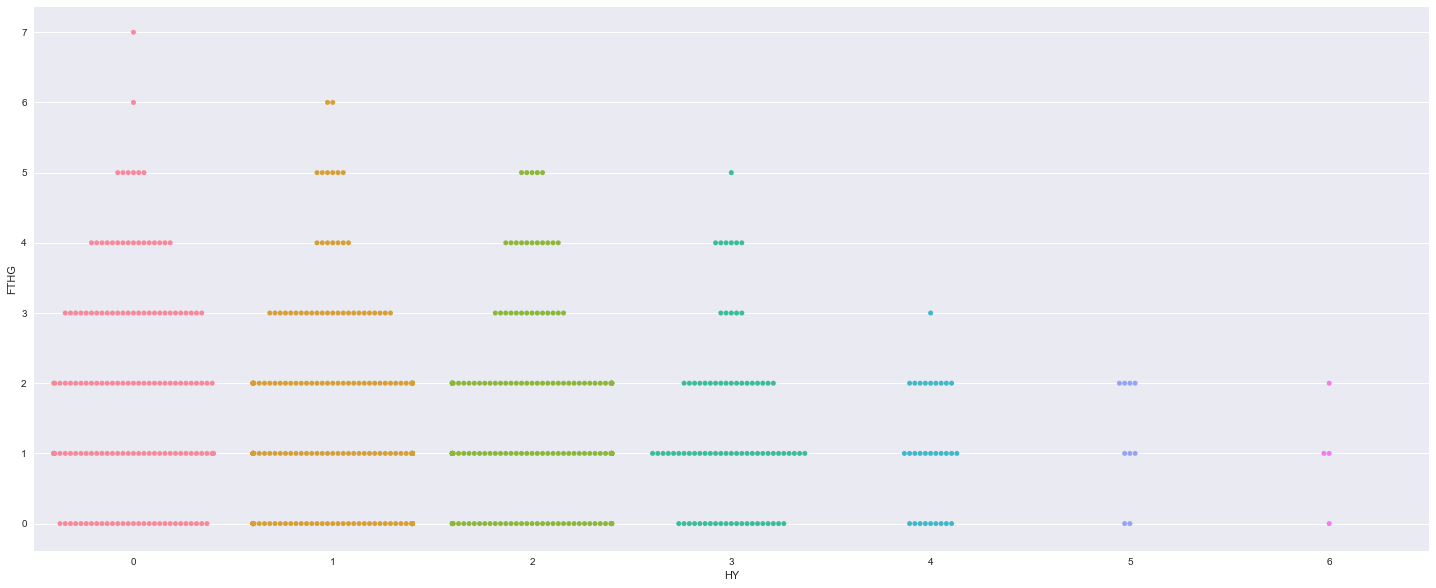

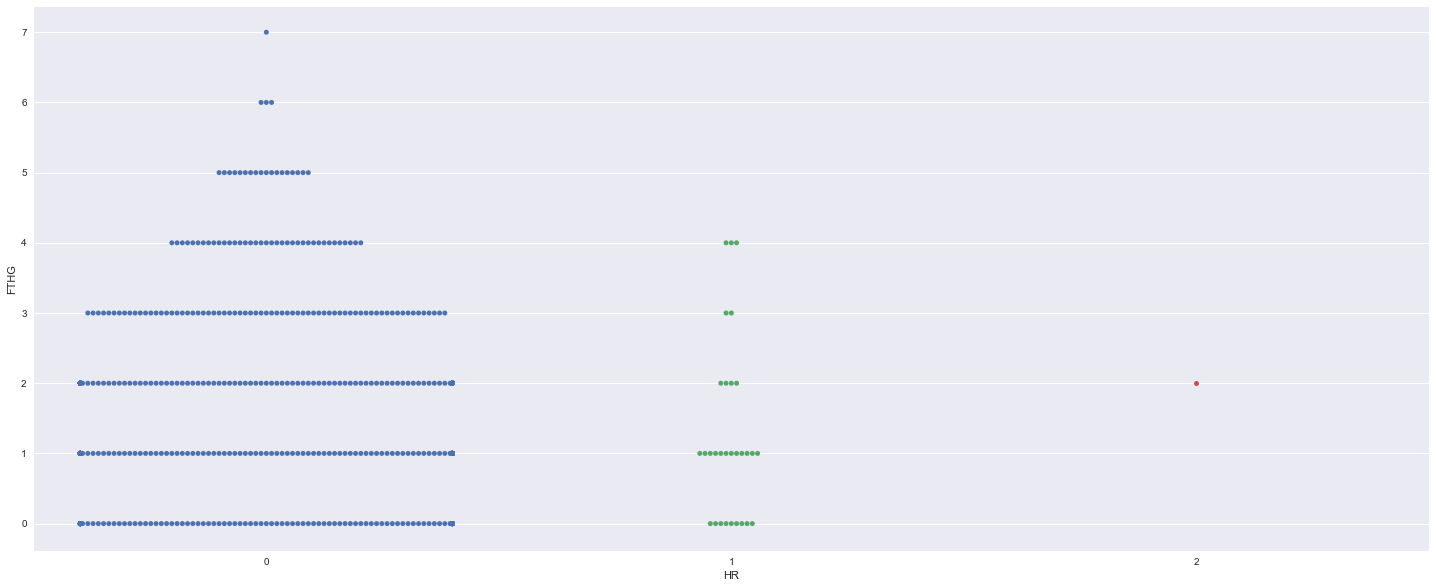

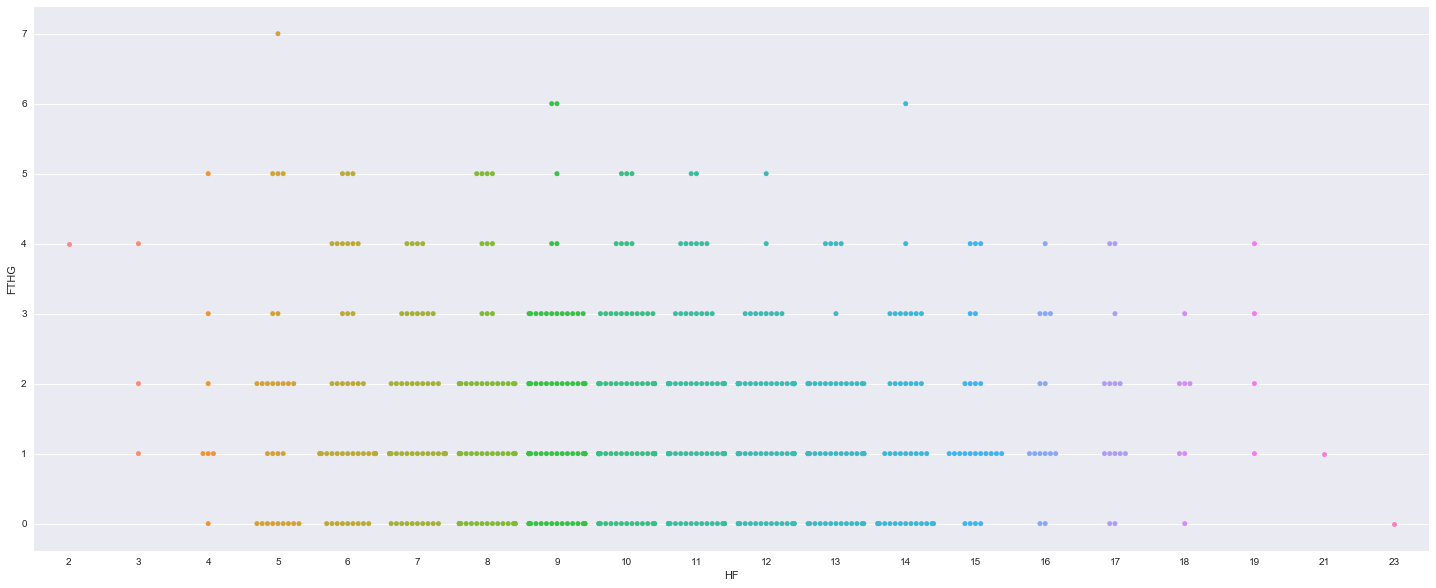

In [15]:
# now lets look at home score swarm plots by home features

total_list = ['HomeTeam', 'Referee','HTHG', 'HS', 
              'HST', 'HC', 'HY', 'HR', 'HF']

for x in total_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.FTHG)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

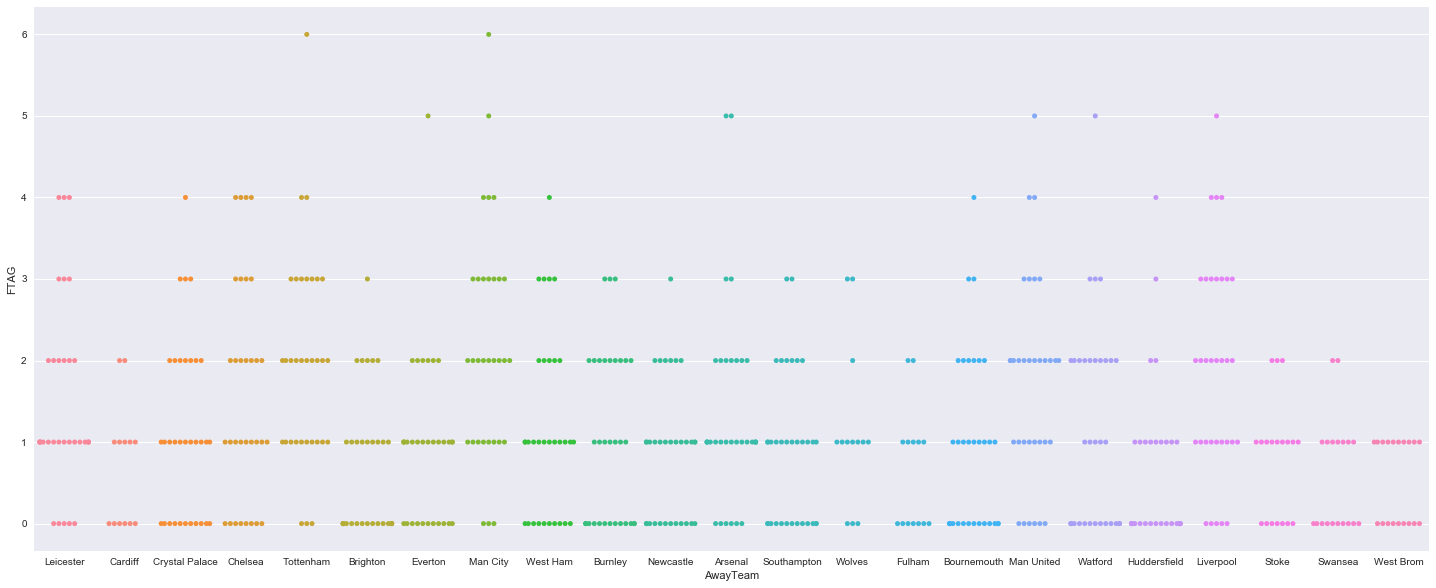

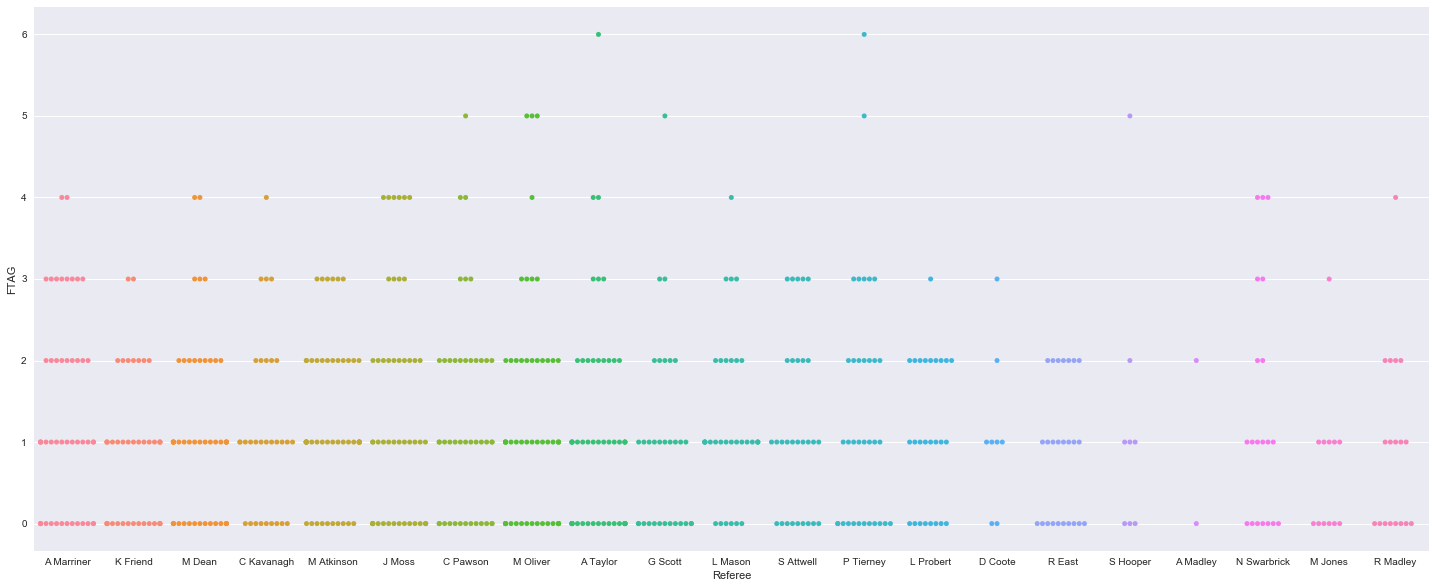

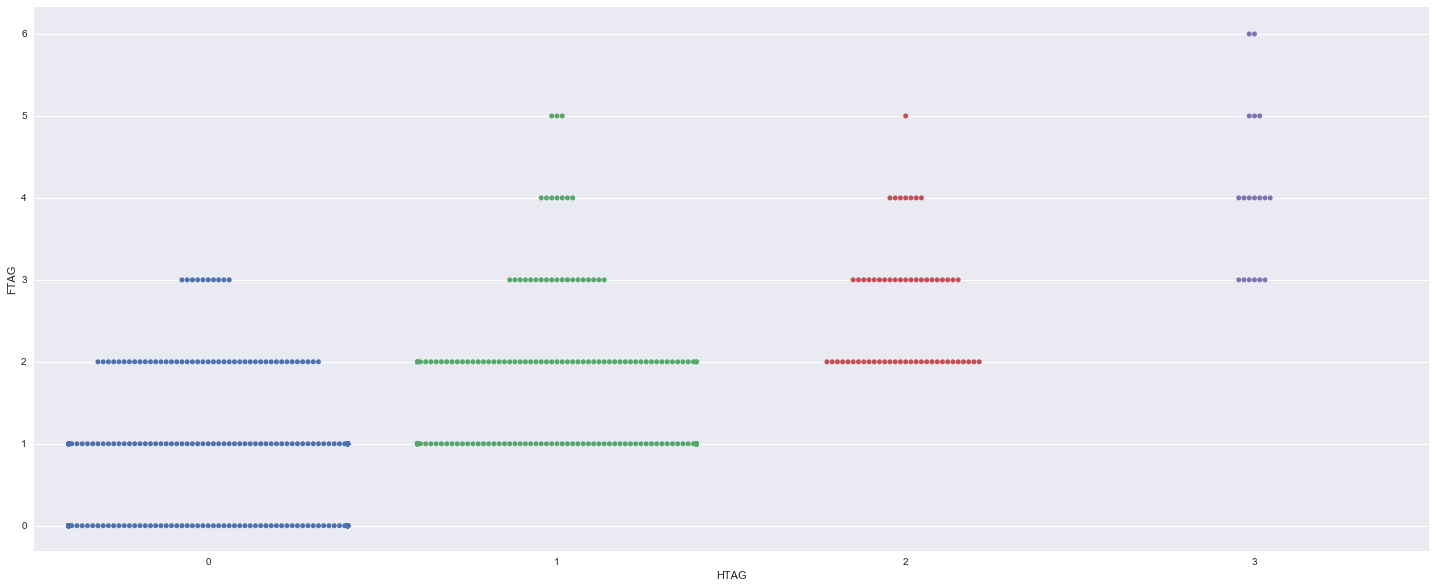

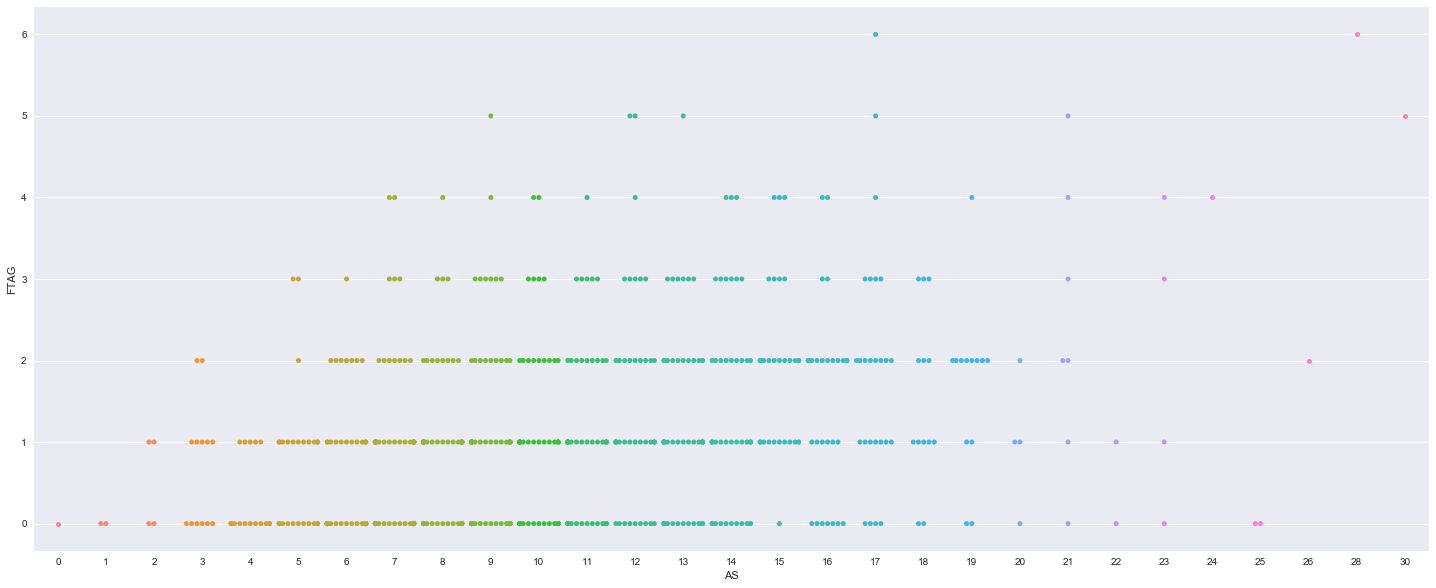

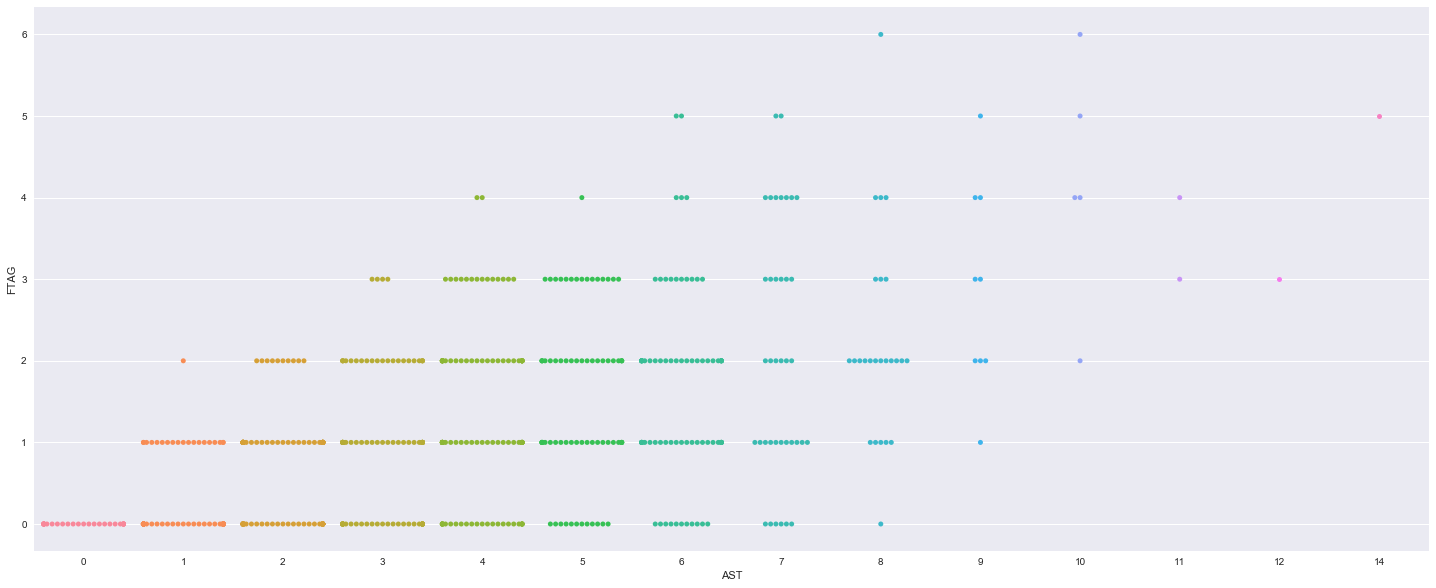

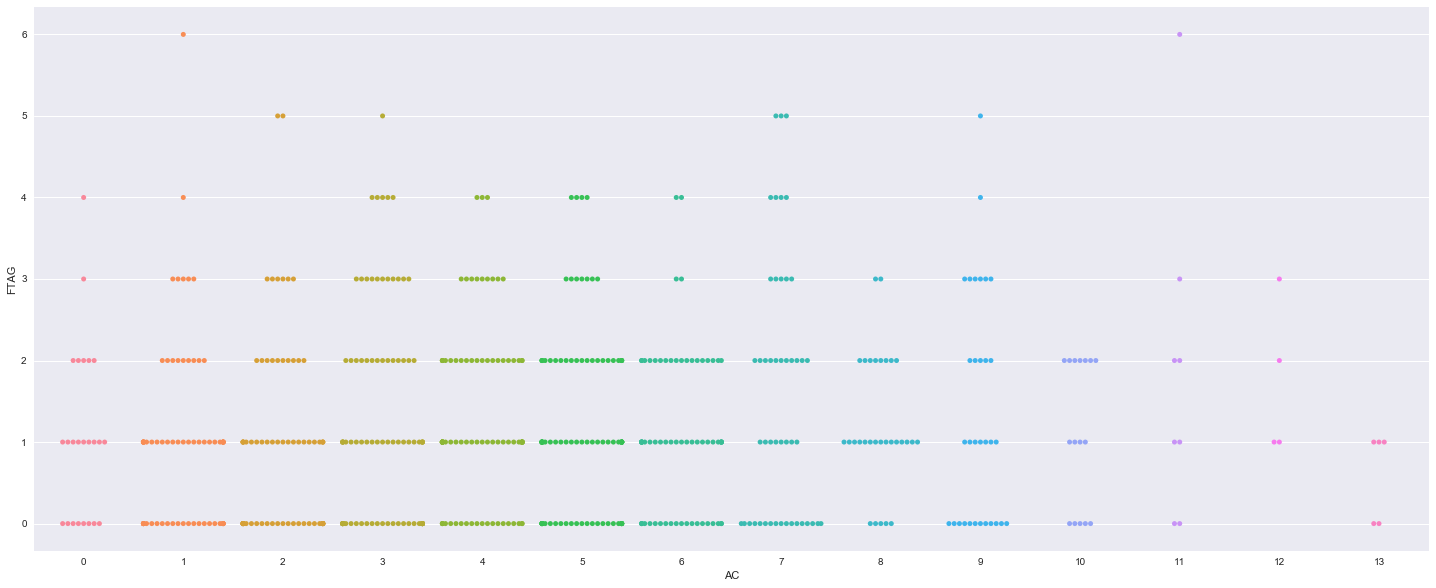

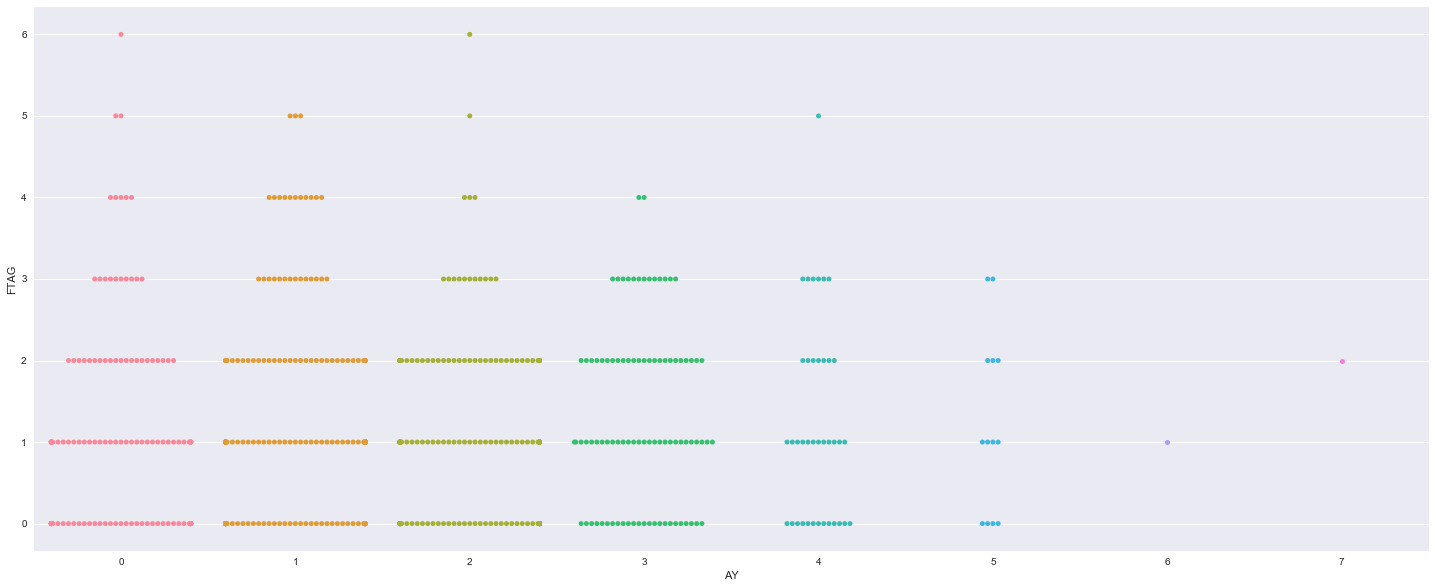

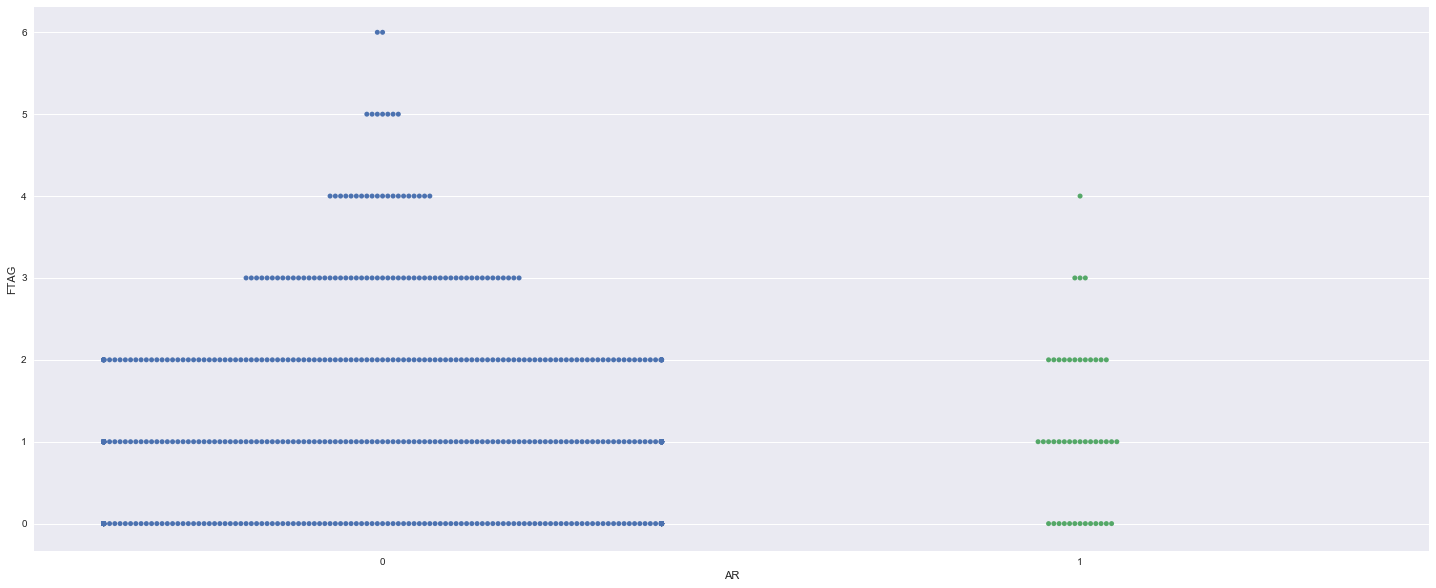

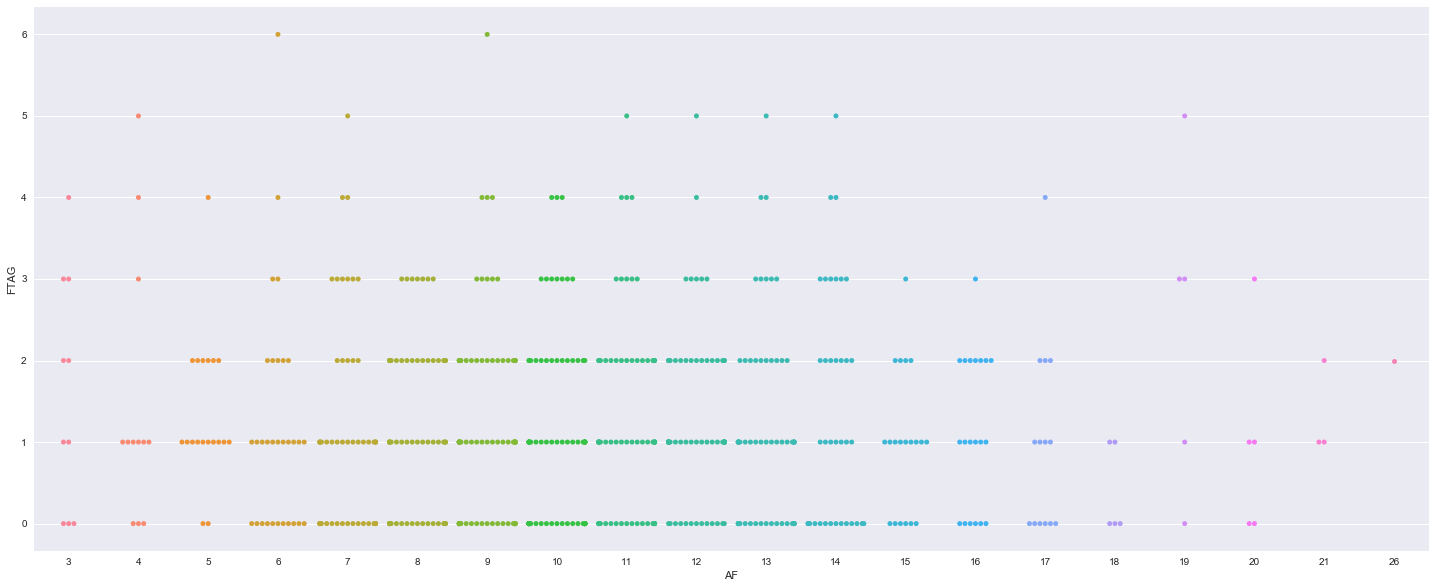

In [16]:
# now lets look at away score swarm plots by away features

away_list = ['AwayTeam', 'Referee','HTAG', 'AS', 
              'AST', 'AC', 'AY', 'AR', 'AF']

for x in away_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.FTAG)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

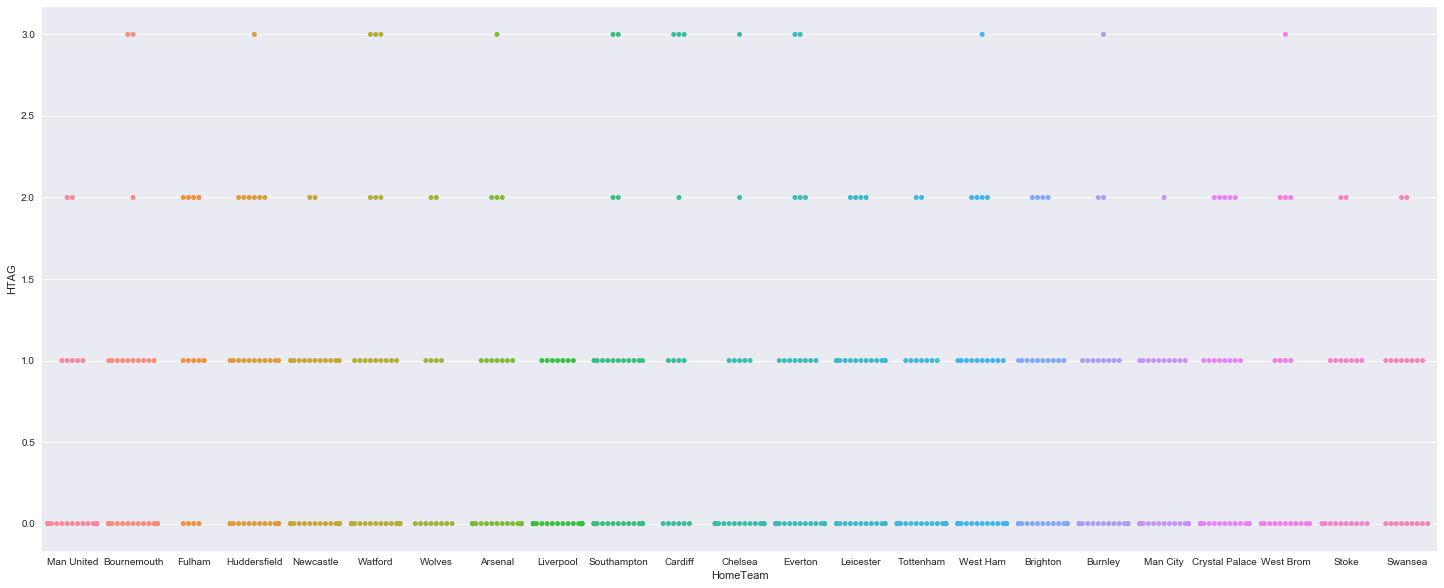

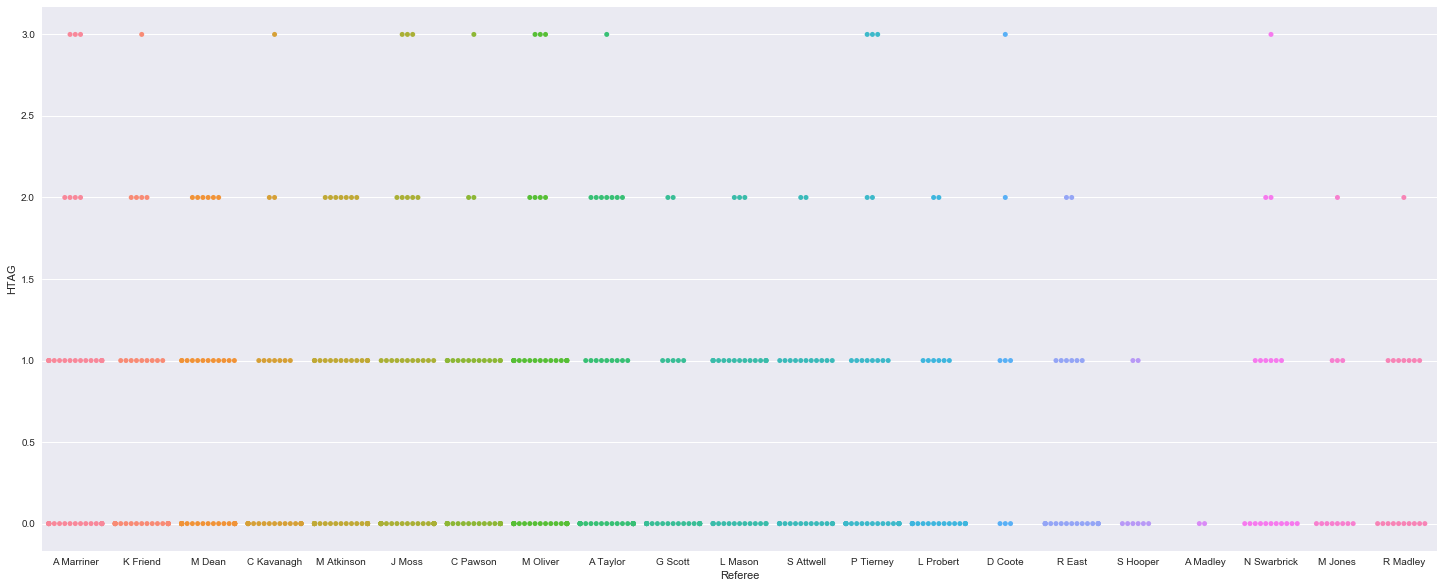

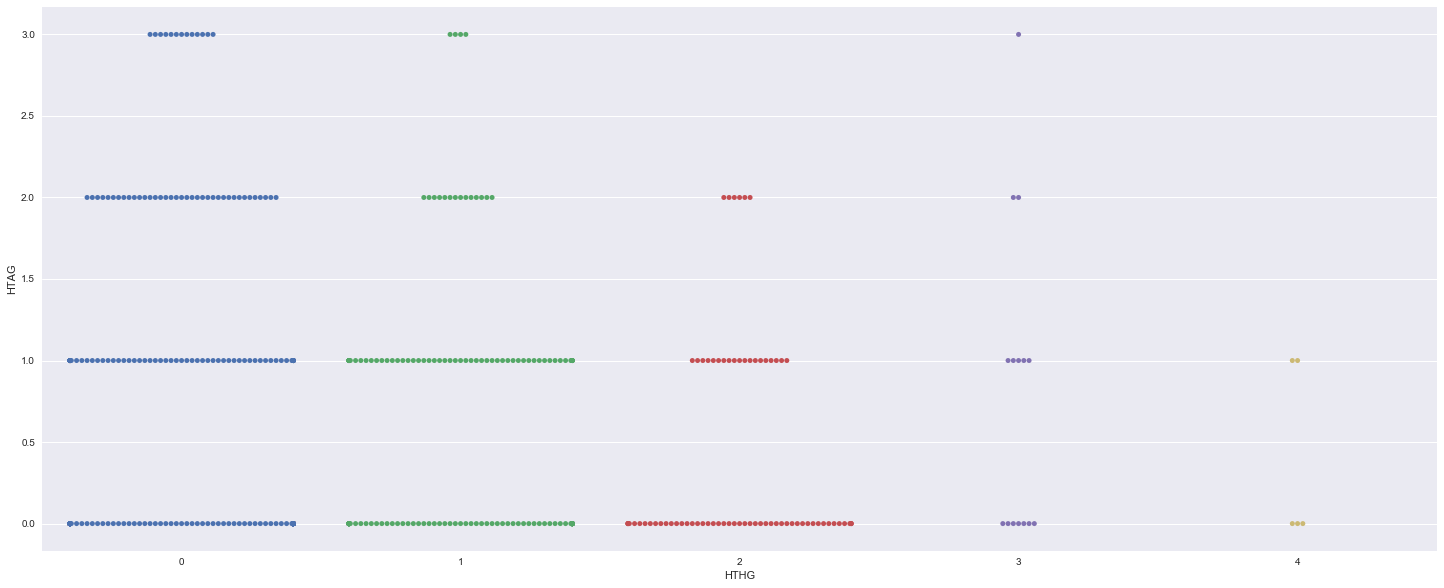

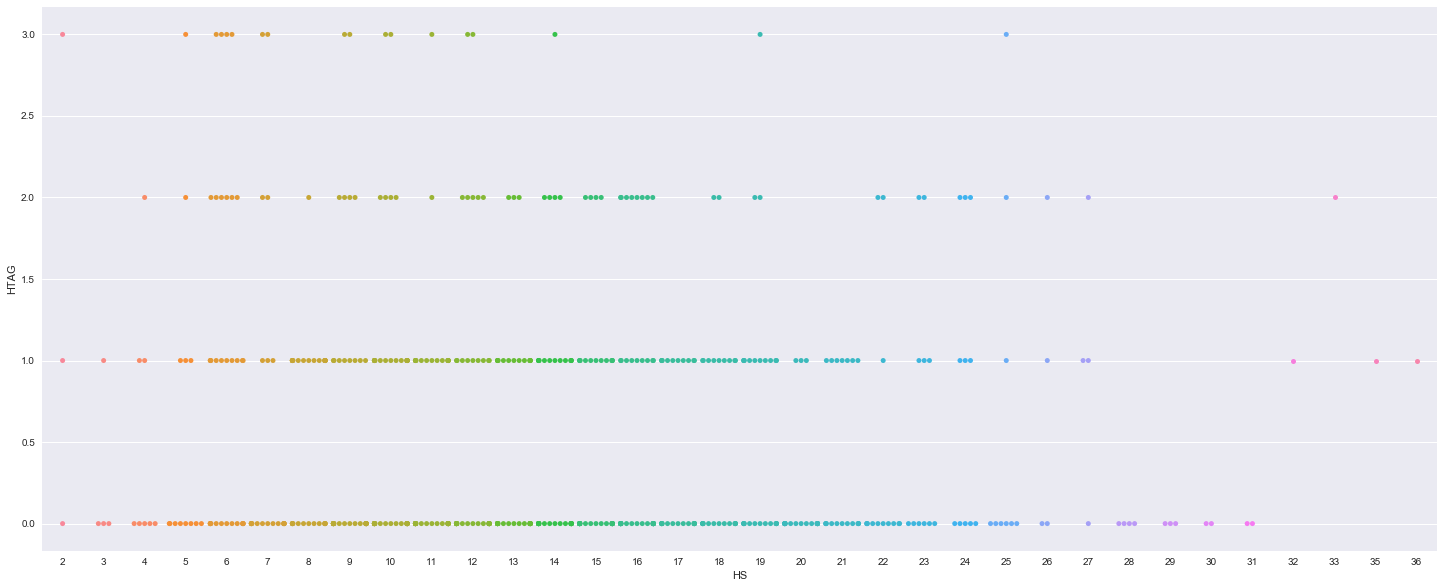

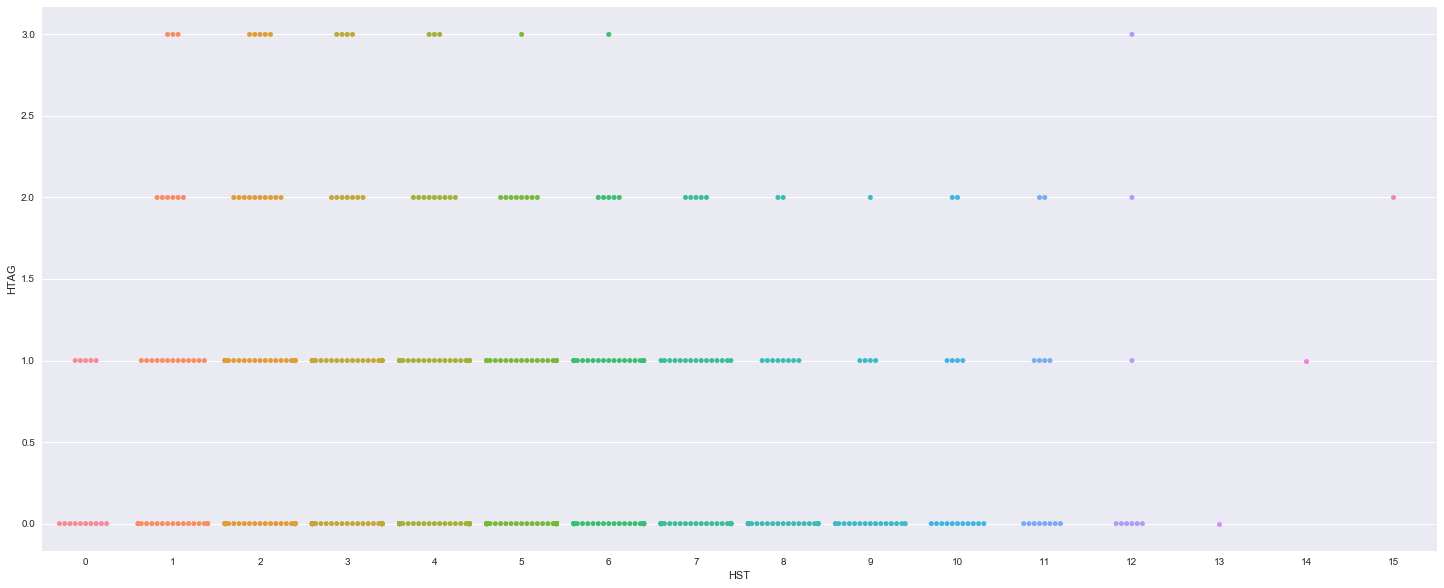

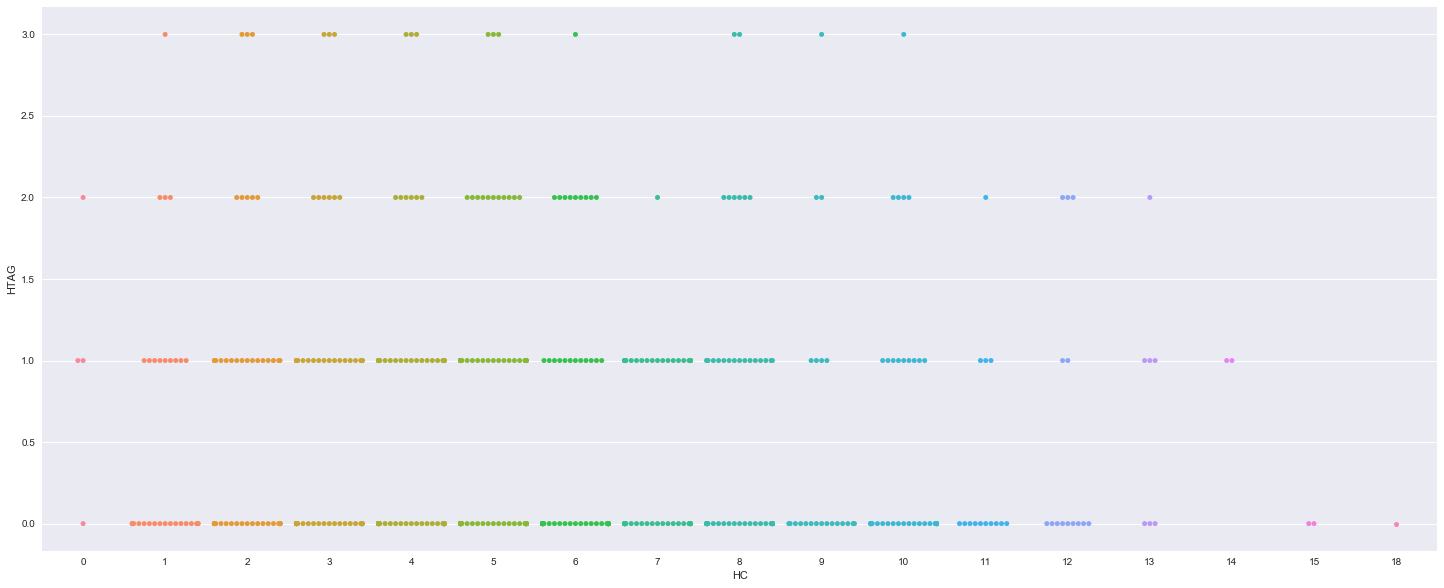

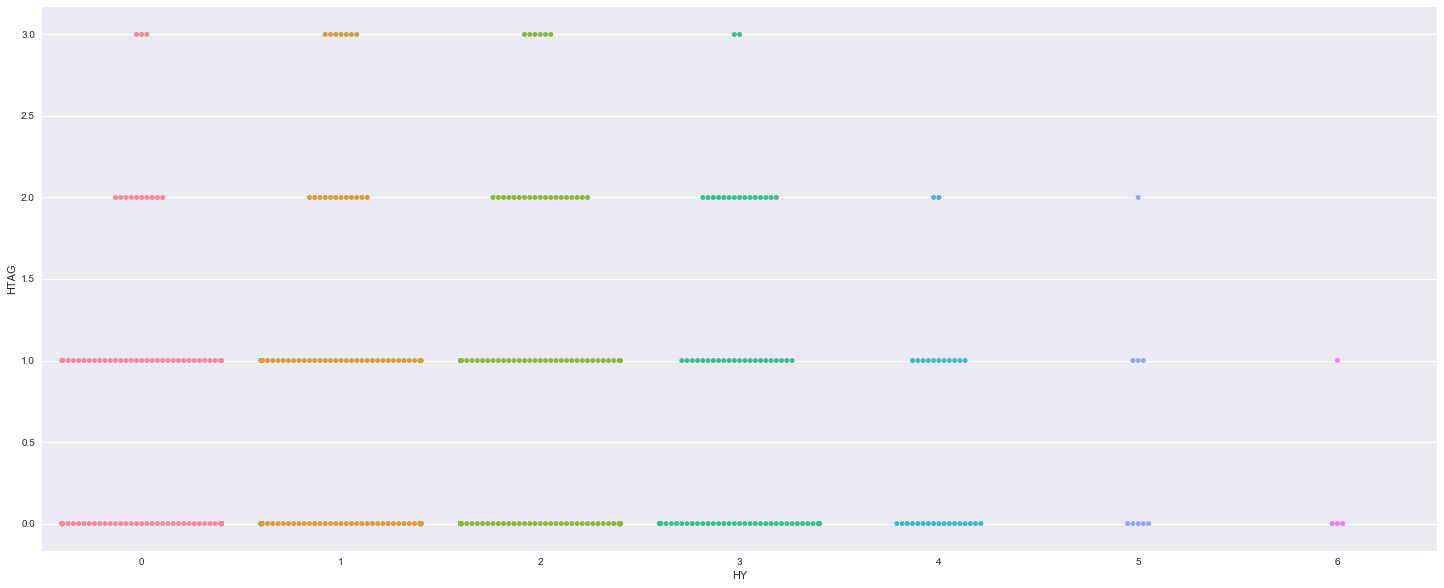

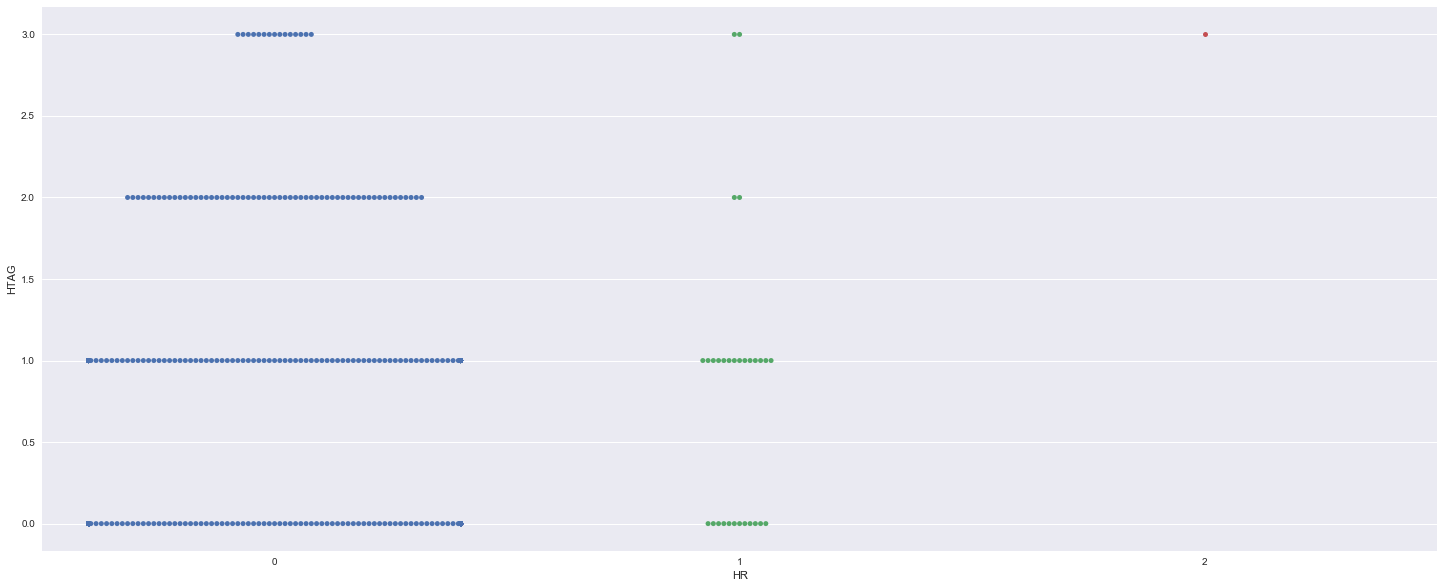

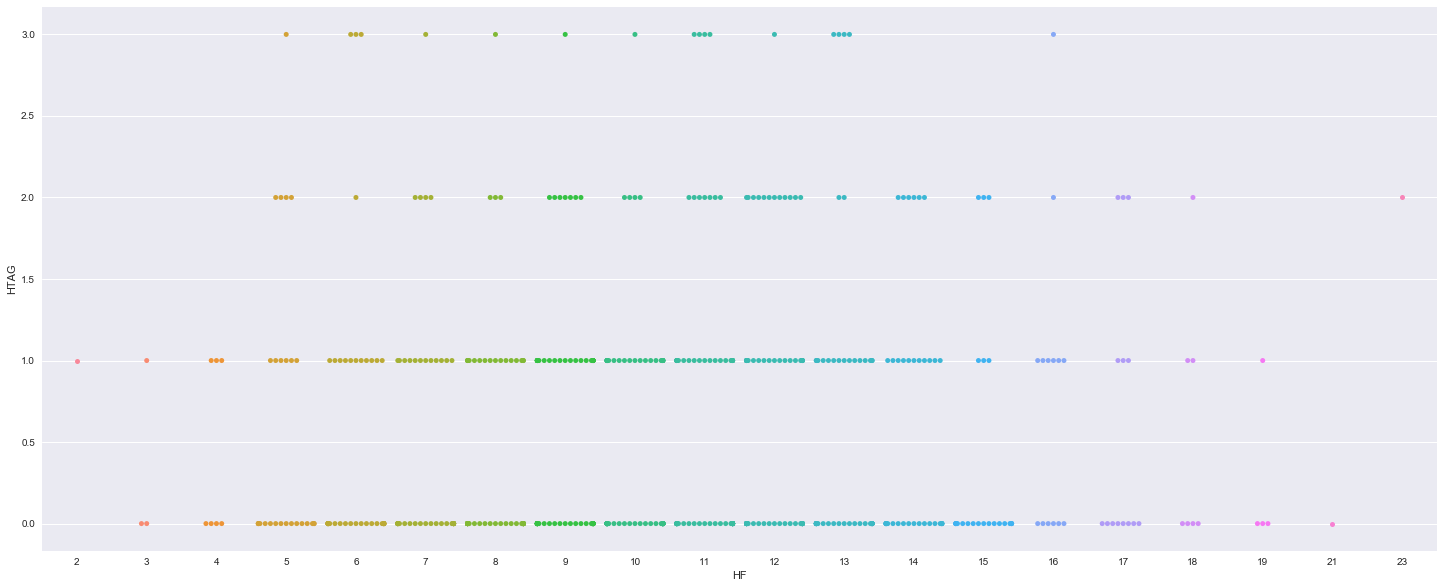

In [17]:
# now lets look at total score swarm plots by home features

home_list = ['HomeTeam', 'Referee','HTHG', 'HS', 
              'HST', 'HC', 'HY', 'HR', 'HF']

for x in home_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.HTAG)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

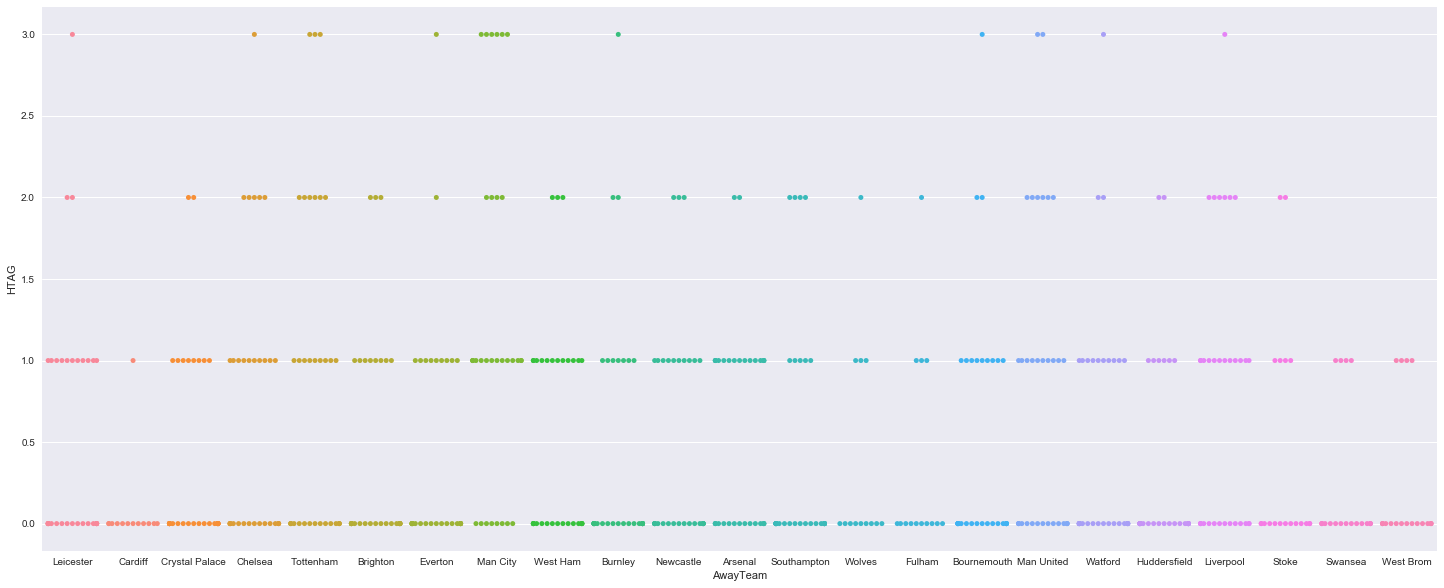

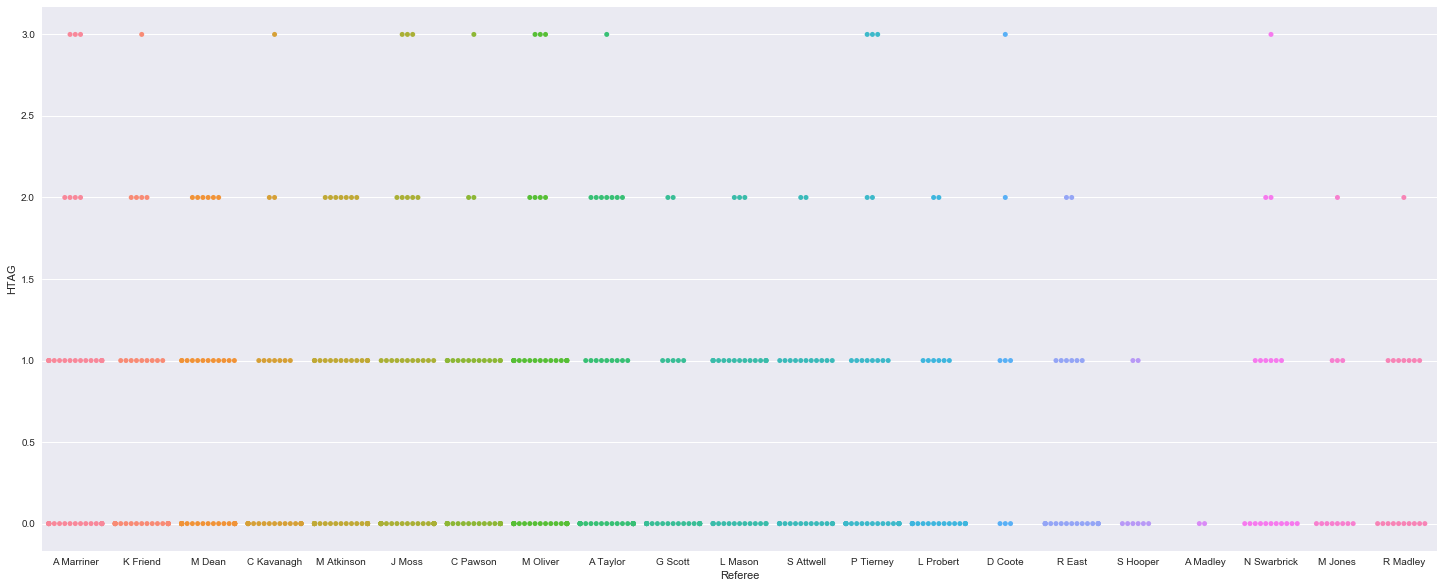

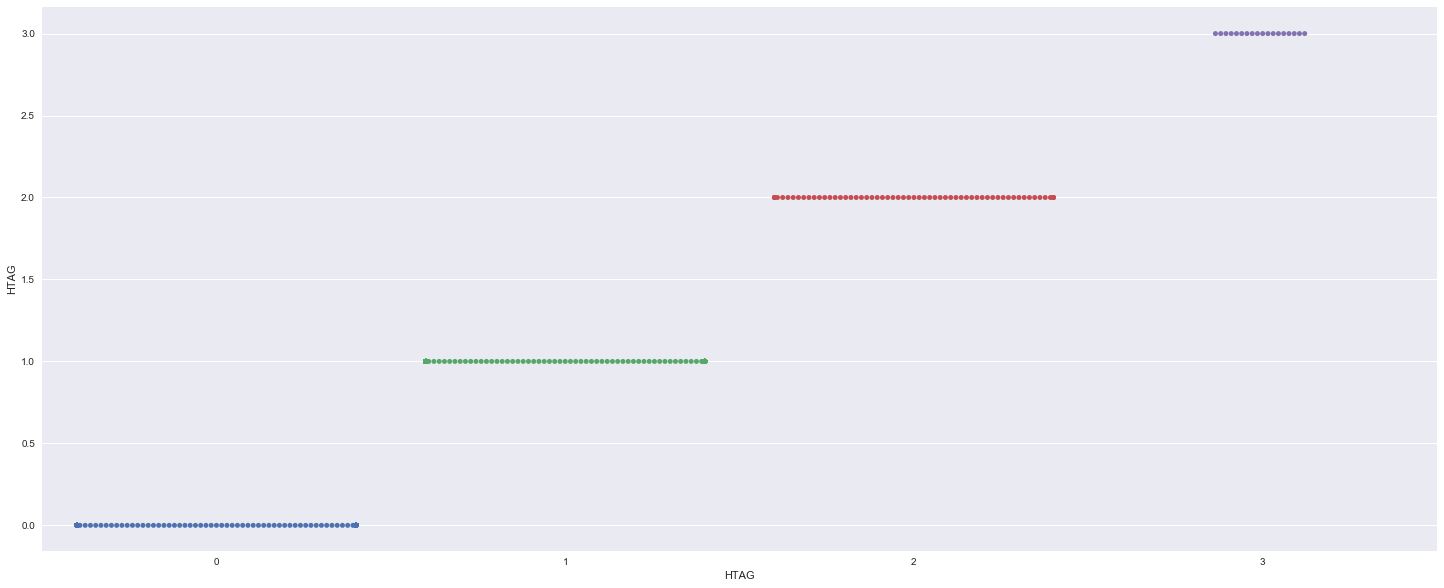

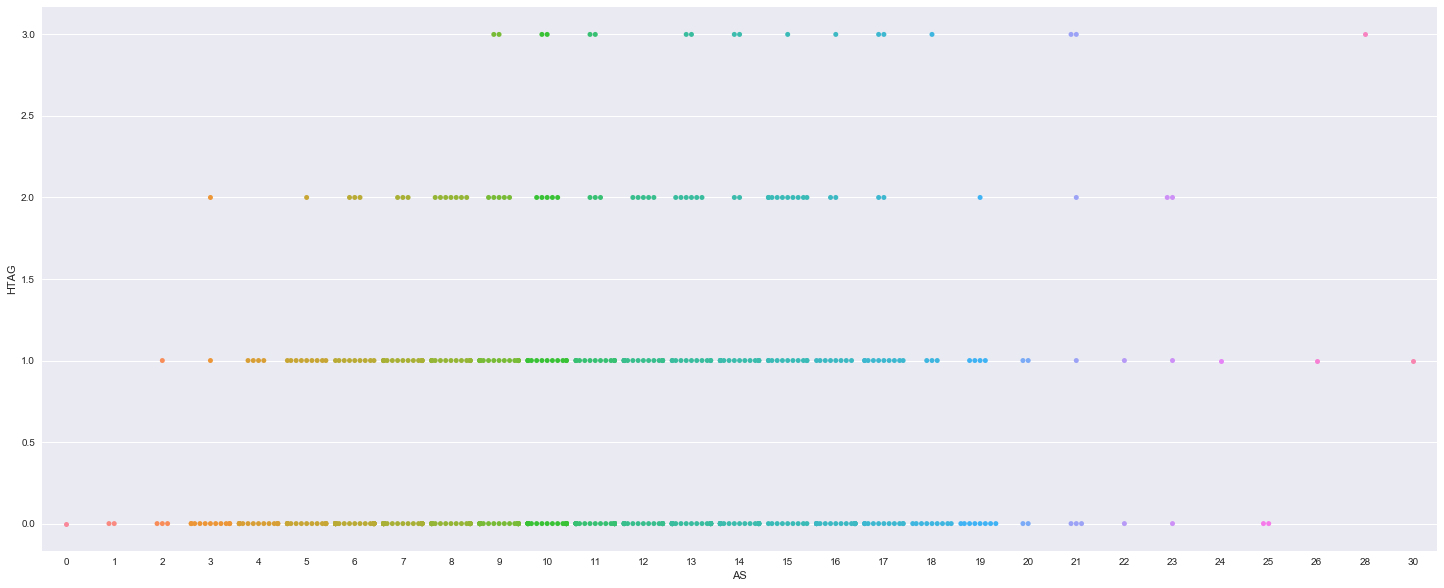

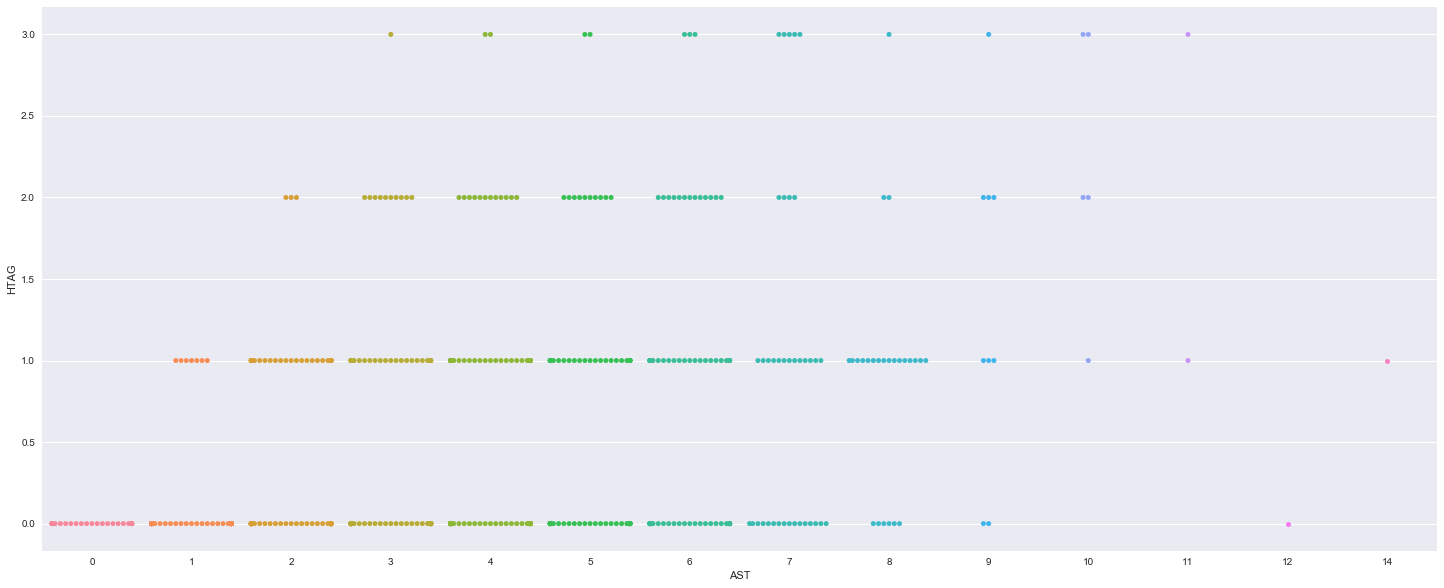

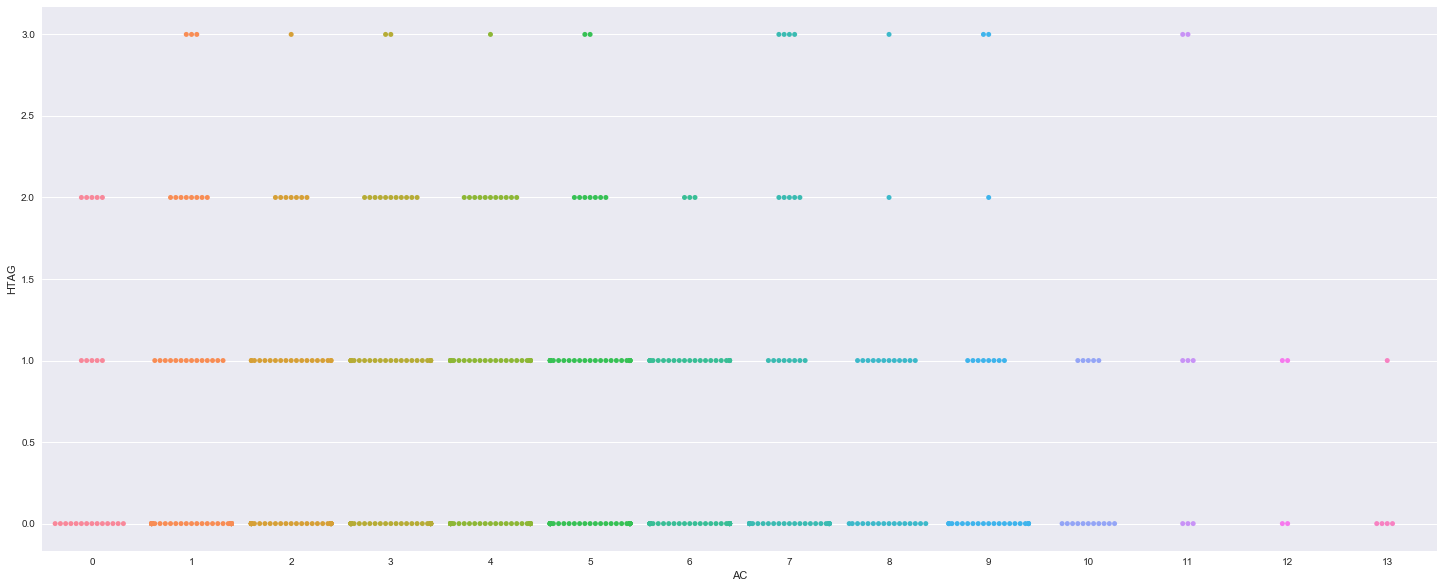

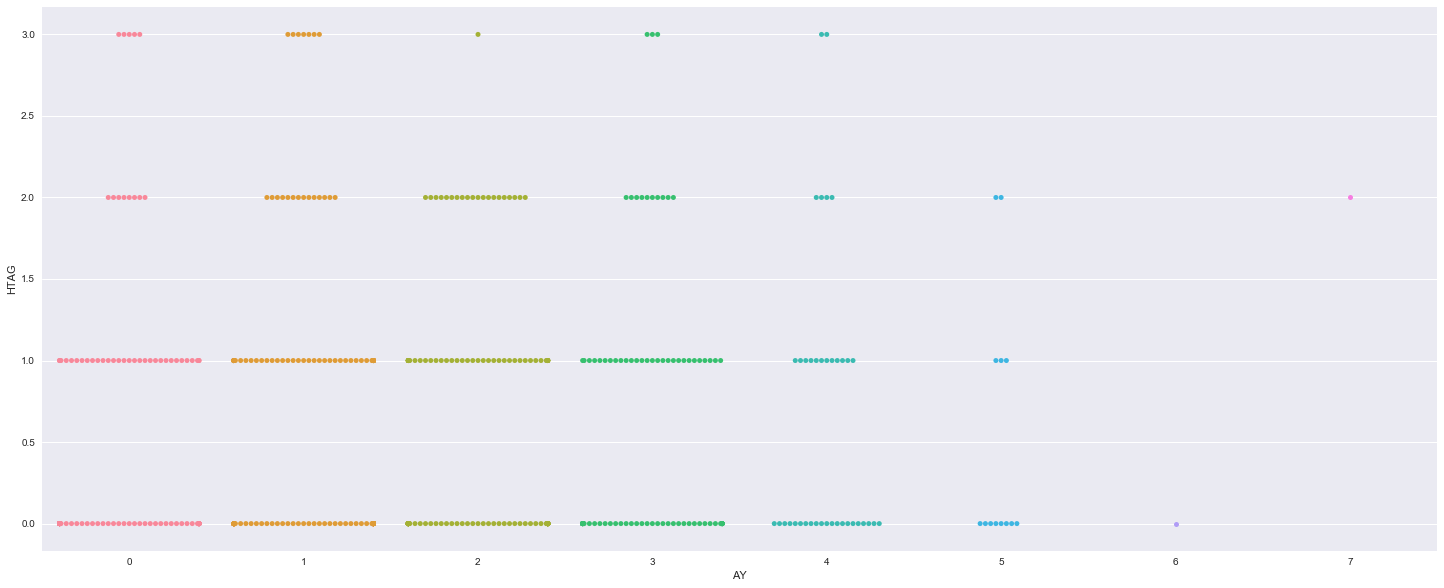

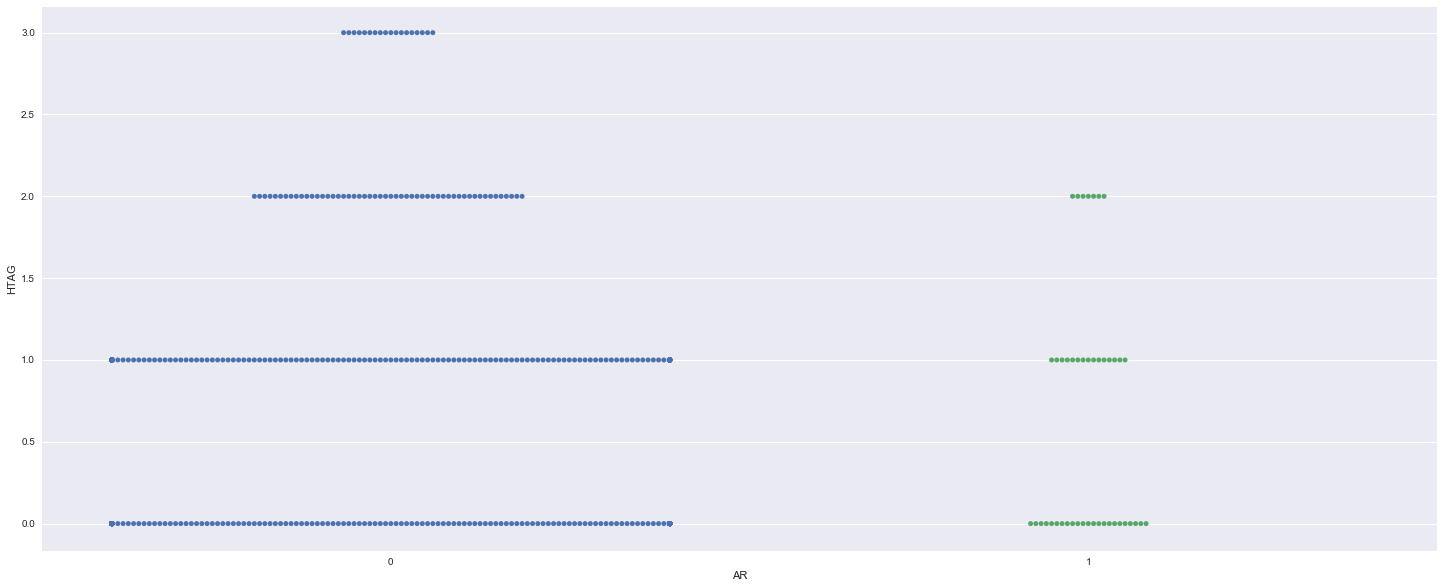

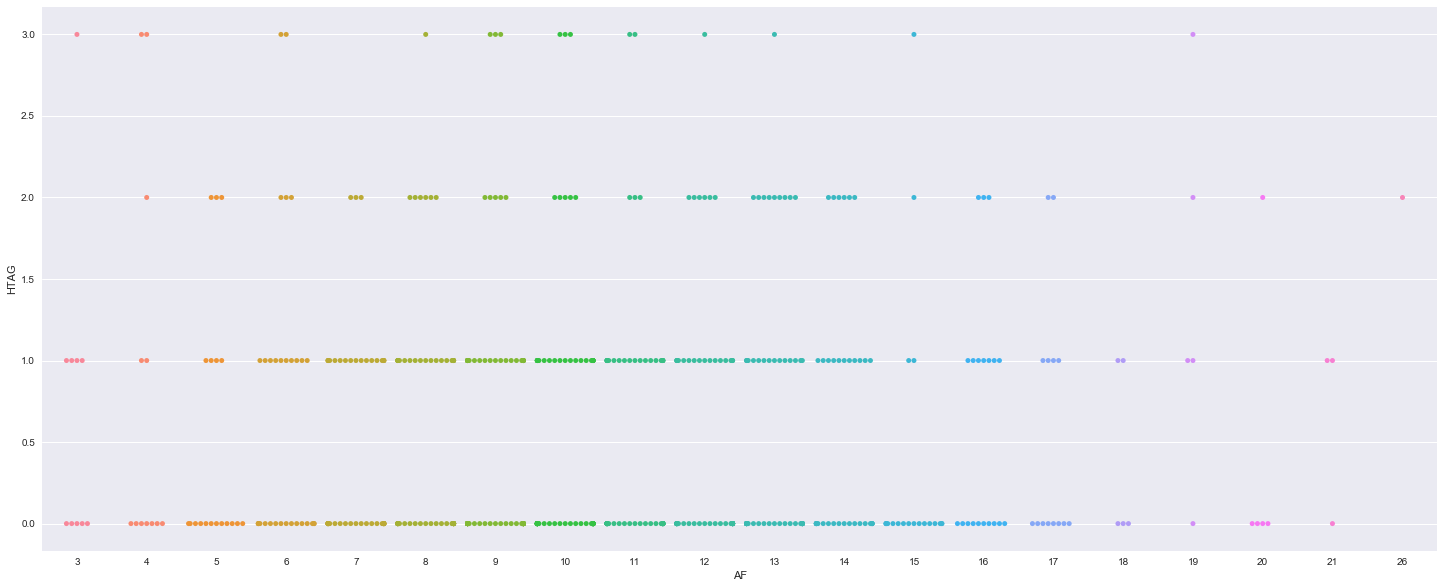

In [18]:
# now lets look at total score swarm plots by away features

away_list = ['AwayTeam', 'Referee','HTAG', 'AS', 
              'AST', 'AC', 'AY', 'AR', 'AF']

for x in away_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.HTAG)

<Figure size 1440x720 with 0 Axes>

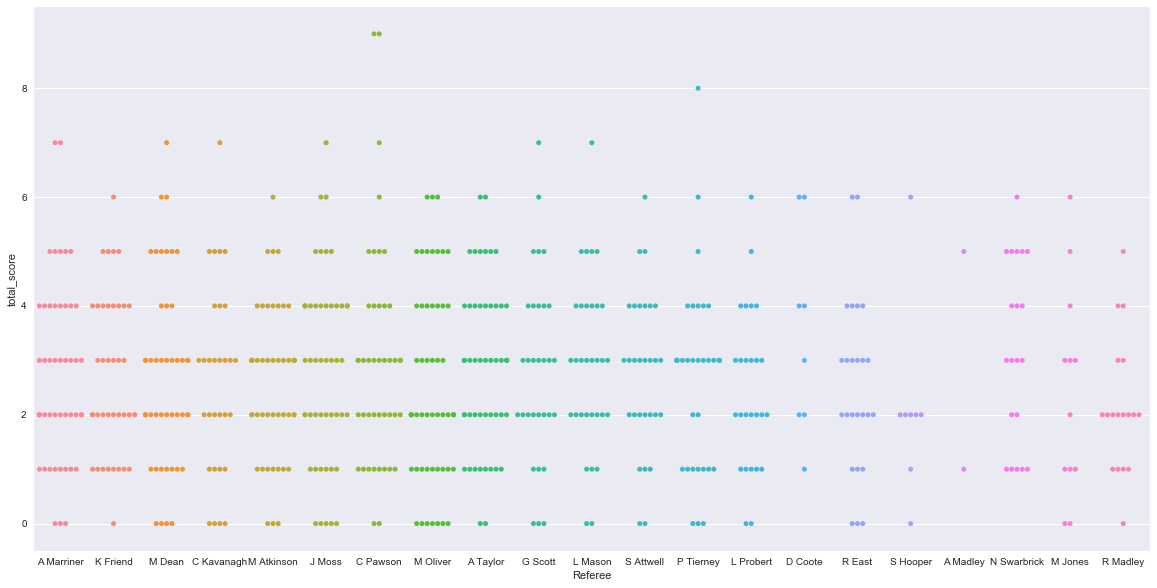

In [19]:
# total score swarmplots by referee
plt.figure(figsize=(20,10)) 
sns.swarmplot(df_total.Referee, df_total.total_score)

<Figure size 1800x720 with 0 Axes>

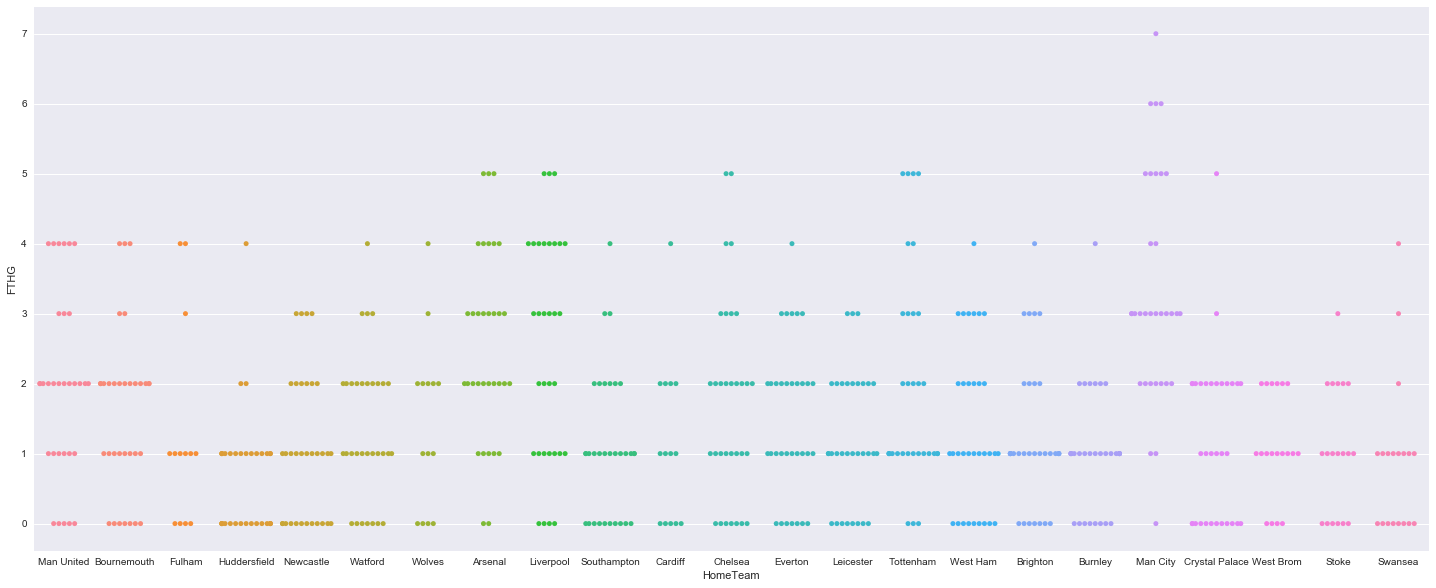

In [20]:
# home score swarmplots by HomeTeam
plt.figure(figsize=(25,10)) 
sns.swarmplot(df_total.HomeTeam, df_total.FTHG)

### Looks like Man City, Man United, and Liverpool (YNWA) have been doing great at home recently which makes sense if you have been following the EPL the past couple seasons

<Figure size 1800x720 with 0 Axes>

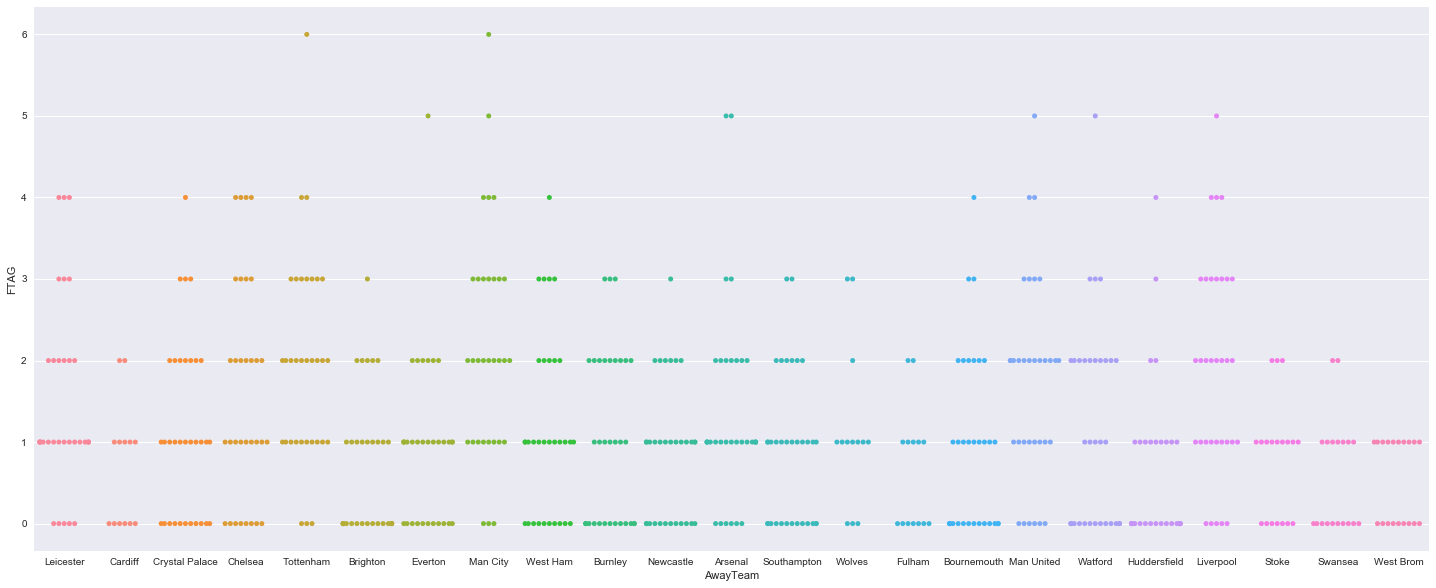

In [21]:
# away score swarmplots by AwayTeam
plt.figure(figsize=(25,10)) 
sns.swarmplot(df_total.AwayTeam, df_total.FTAG)

### looks like Spurs, Man City, and Liverpool (YNWA) have been doing great away from home lately which makes sense if you have been following the EPL the past couple seasons

<Figure size 1440x720 with 0 Axes>

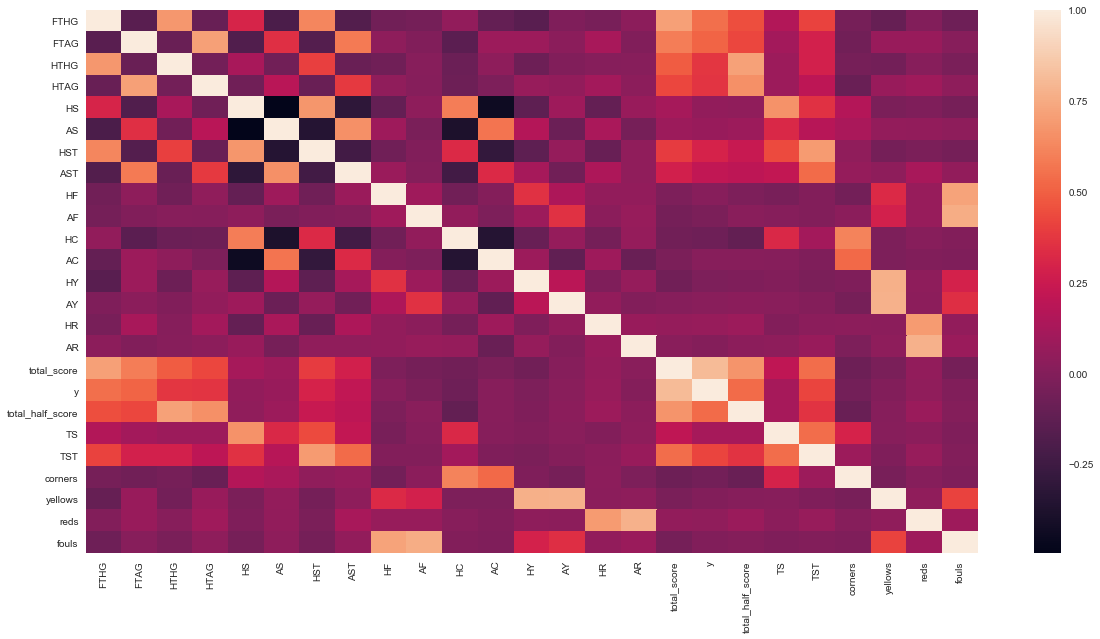

In [22]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df_total.corr())
plt.show()

In [ ]:
pp1 = pd.concat([df_total[['y']], df_total.iloc[:, 1:26]])
pp2 = pd.concat([df_total[['y']], df_total.iloc[:, 26:51]])
pp3 = pd.concat([df_total[['y']], df_total.iloc[:, 51:76]])
pp4 = pd.concat([df_total[['y']], df_total.iloc[:, 76:]])


sns.pairplot(pp1, hue='y')
plt.figure(figsize=(25,10)) 
plt.show()

/Users/daviddansby/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
/Users/daviddansby/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
/Users/daviddansby/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.


Traceback (most recent call last):
  File "/Users/daviddansby/anaconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-3a9de80d2a14>", line 7, in <module>
    sns.pairplot(pp1, hue='y')
  File "/Users/daviddansby/anaconda/lib/python3.7/site-packages/seaborn/axisgrid.py", line 2121, in pairplot
    plotter(scatterplot, **plot_kws)
  File "/Users/daviddansby/anaconda/lib/python3.7/site-packages/seaborn/axisgrid.py", line 1512, in map_offdiag
    self.map_lower(func, **kwargs)
  File "/Users/daviddansby/anaconda/lib/python3.7/site-packages/seaborn/axisgrid.py", line 1442, in map_lower
    color=color, **kwargs)
  File "/Users/daviddansby/anaconda/lib/python3.7/site-packages/seaborn/relational.py", line 1341, in scatterplot
    p.plot(ax, kwargs)
  File "/Users/daviddansby/anaconda/lib/python3.7/site-packages/seaborn/relational.py", line 927, in plot
    self.label_axes(ax)

KeyboardInterrupt: 

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [122]:
df_total = pd.get_dummies(data=df_total, columns=['HomeTeam'],prefix='home')
df_total = pd.get_dummies(data=df_total, columns=['AwayTeam'],prefix='away')
df_total = pd.get_dummies(data=df_total, columns=['Referee'],prefix='ref')

df_total.info()
df_total.describe()
df_total.head()
df_total.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 93 columns):
Date                   object
FTHG                   int64
FTAG                   int64
HTHG                   int64
HTAG                   int64
HS                     int64
AS                     int64
HST                    int64
AST                    int64
HF                     int64
AF                     int64
HC                     int64
AC                     int64
HY                     int64
AY                     int64
HR                     int64
AR                     int64
total_score            int64
y                      int64
total_half_score       int64
TS                     int64
TST                    int64
corners                int64
yellows                int64
reds                   int64
fouls                  int64
home_Arsenal           uint8
home_Bournemouth       uint8
home_Brighton          uint8
home_Burnley           uint8
home_Cardiff           u

FTHG        FTAG        HTHG        HTAG          HS          AS  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean     1.540832    1.201849    0.644068    0.548536   13.830508   10.873652   
std      1.338628    1.173629    0.832203    0.772523    5.854111    4.612389   
min      0.000000    0.000000    0.000000    0.000000    2.000000    0.000000   
25%      1.000000    0.000000    0.000000    0.000000   10.000000    7.000000   
50%      1.000000    1.000000    0.000000    0.000000   13.000000   10.000000   
75%      2.000000    2.000000    1.000000    1.000000   17.000000   14.000000   
max      7.000000    6.000000    4.000000    3.000000   36.000000   30.000000   

              HST         AST          HF          AF          HC          AC  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean     4.733436    3.852080   10.363636   10.457627    5.736518    4.531587   
std      2.704844    2.297274    3.234694    3.448717    2.955416    2.752553   
min      0.000000    0.000000    2.000000    3.000000    0.000000    0.000000   
25%      3.000000    2.000000    8.000000    8.000000    4.000000    2.000000   
50%      4.000000    4.000000   10.000000   10.000000    5.000000    4.000000   
75%      6.000000    5.000000   12.000000   13.000000    8.000000    6.000000   
max     15.000000   14.000000   23.000000   26.000000   18.000000   13.000000   

               HY          AY          HR          AR  total_score  \
count  649.000000  649.000000  649.000000  649.000000   649.000000   
mean     1.505393    1.627119    0.049307    0.069337     2.742681   
std      1.241161    1.252012    0.223683    0.254223     1.645246   
min      0.000000    0.000000    0.000000    0.000000     0.000000   
25%      1.000000    1.000000    0.000000    0.000000     2.000000   
50%      1.000000    1.000000    0.000000    0.000000     3.000000   
75%      2.000000    2.000000    0.000000    0.000000     4.000000   
max      6.000000    7.000000    2.000000    1.000000     9.000000   

                y  total_half_score          TS         TST     corners  \
count  649.000000        649.000000  649.000000  649.000000  649.000000   
mean     0.530046          1.192604   24.704160    8.585516   10.268105   
std      0.499481          1.104791    5.362938    3.107017    3.266305   
min      0.000000          0.000000   11.000000    1.000000    2.000000   
25%      0.000000          0.000000   21.000000    6.000000    8.000000   
50%      1.000000          1.000000   25.000000    8.000000   10.000000   
75%      1.000000          2.000000   28.000000   10.000000   13.000000   
max      1.000000          6.000000   42.000000   19.000000   21.000000   

          yellows        reds       fouls  home_Arsenal  home_Bournemouth  \
count  649.000000  649.000000  649.000000    649.000000        649.000000   
mean     3.132512    0.118644   20.821263      0.050847          0.050847   
std      1.925545    0.351066    4.946202      0.219856          0.219856   
min      0.000000    0.000000    8.000000      0.000000          0.000000   
25%      2.000000    0.000000   18.000000      0.000000          0.000000   
50%      3.000000    0.000000   21.000000      0.000000          0.000000   
75%      4.000000    0.000000   24.000000      0.000000          0.000000   
max     10.000000    2.000000   36.000000      1.000000          1.000000   

       home_Brighton  home_Burnley  home_Cardiff  home_Chelsea  \
count     649.000000    649.000000    649.000000    649.000000   
mean        0.049307      0.049307      0.021572      0.049307   
std         0.216674      0.216674      0.145392      0.216674   
min         0.000000      0.000000      0.000000      0.000000   
25%         0.000000      0.000000      0.000000      0.000000   
50%         0.000000      0.000000      0.000000      0.000000   
75%         0.000000      0.000000      0.000000      0.000000   
max         1.000000    

Date  FTHG  FTAG  HTHG  HTAG  HS  AS  HST  AST  HF  AF  HC  AC  HY  \
0  2018-08-10     2     1     1     0   8  13    6    4  11   8   2   5   2   
1  2018-08-11     2     0     1     0  12  10    4    1  11   9   7   4   1   
2  2018-08-11     0     2     0     1  15  10    6    9   9  11   5   5   1   
3  2018-08-11     0     3     0     2   6  13    1    4   9   8   2   5   2   
4  2018-08-11     1     2     1     2  15  15    2    5  11  12   3   5   2   

   AY  HR  AR  total_score  y  total_half_score  TS  TST  corners  yellows  \
0   1   0   0            3  1                 1  21   10        7        3   
1   1   0   0            2  0                 1  22    5       11        2   
2   2   0   0            2  0                 1  25   15       10        3   
3   1   0   0            3  1                 2  19    5        7        3   
4   2   0   0            3  1                 3  30    7        8        4   

   reds  fouls  home_Arsenal  home_Bournemouth  home_Brighton  home_Burnley  \
0     0     19             0                 0              0             0   
1     0     20             0                 1              0             0   
2     0     20             0                 0              0             0   
3     0     17             0                 0              0             0   
4     0     23             0                 0              0             0   

   home_Cardiff  home_Chelsea  home_Crystal Palace  home_Everton  home_Fulham  \
0             0             0                    0             0            0   
1             0             0                    0             0            0   
2             0             0                    0             0            1   
3             0             0                    0             0            0   
4             0             0                    0             0            0   

   home_Huddersfield  home_Leicester  home_Liverpool  home_Man City  \
0                  0               0               0              0   
1                  0               0               0              0   
2                  0               0               0              0   
3                  1               0               0              0   
4                  0               0               0              0   

   home_Man United  home_Newcastle  home_Southampton  home_Stoke  \
0                1               0                 0           0   
1                0               0                 0           0   
2                0               0                 0           0   
3                0               0                 0           0   
4                0               1                 0           0   

   home_Swansea  home_Tottenham  home_Watford  home_West Brom  home_West Ham  \
0             0               0             0               0              0   
1             0               0             0               0              0   
2             0               0             0               0              0   
3             0               0             0               0              0   
4             0               0             0               0              0   

   home_Wolves  away_Arsenal  away_Bournemouth  away_Brighton  away_Burnley  \
0            0             0                 0              0             0   
1            0             0                 0              0             0   
2            0             0                 0              0             0   
3            0             0                 0              0             0   
4            0             0                 0              0             0   

   away_Cardiff  away_Chelsea  away_Crystal Palace  away_Everton  away_Fulham  \
0             0             0                    0             0            0   
1             1             0                    0             0            0   
2             0             0                    1             0    

Date  FTHG  FTAG  HTHG  HTAG  HS  AS  HST  AST  HF  AF  HC  AC  HY  \
644  2018-05-13     3     0     1     0  16   6    6    2  11  10   4   2   0   
645  2018-05-13     0     1     0     0   8  13    3    2   8  10   1  12   3   
646  2018-05-13     1     2     1     2  26   8   11    5  12   9   6   0   1   
647  2018-05-13     5     4     1     2  14  16    6    9   9  13   4   4   1   
648  2018-05-13     3     1     1     0  15  14    4    7  10  13   6   6   0   

     AY  HR  AR  total_score  y  total_half_score  TS  TST  corners  yellows  \
644   1   0   0            3  1                 1  22    8        6        1   
645   1   0   0            1  0                 0  21    5       13        4   
646   2   0   0            3  1                 3  34   16        6        3   
647   2   0   0            9  1                 3  30   15        8        3   
648   1   0   0            4  1                 1  29   11       12        1   

     reds  fouls  home_Arsenal  home_Bournemouth  home_Brighton  home_Burnley  \
644     0     21             0                 0              0             0   
645     0     18             0                 0              0             0   
646     0     21             0                 0              0             0   
647     0     22             0                 0              0             0   
648     0     23             0                 0              0             0   

     home_Cardiff  home_Chelsea  home_Crystal Palace  home_Everton  \
644             0             0                    0             0   
645             0             0                    0             0   
646             0             0                    0             0   
647             0             0                    0             0   
648             0             0                    0             0   

     home_Fulham  home_Huddersfield  home_Leicester  home_Liverpool  \
644            0                  0               0               0   
645            0                  0               0               0   
646            0                  0               0               0   
647            0                  0               0               0   
648            0                  0               0               0   

     home_Man City  home_Man United  home_Newcastle  home_Southampton  \
644              0                0               1                 0   
645              0                0               0                 1   
646              0                0               0                 0   
647              0                0               0                 0   
648              0                0               0                 0   

     home_Stoke  home_Swansea  home_Tottenham  home_Watford  home_West Brom  \
644           0             0               0             0               0   
645           0             0               0             0               0   
646           0             1               0             0               0   
647           0             0               1             0               0   
648           0             0               0             0               0   

     home_West Ham  home_Wolves  away_Arsenal  away_Bournemouth  \
644              0            0             0                 0   
645              0            0             0                 0   
646              0            0             0                 0   
647              0            0             0                 0   
648              1            0             0                 0   

     away_Brighton  away_Burnley  away_Cardiff  away_Chelsea  \
644              0             0             0             1   
645              0             0             0             0   
646              0             0             0             0   
647              0             0             0             0   
648              0             0             0             0   

     a

In [123]:
df_total.insert(loc=0, column='y', 
              value=df_total.y, 
              allow_duplicates=True) # move y to front of dataframe
df_total.info()
df_total.head()
df_total.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 94 columns):
y                      int64
Date                   object
FTHG                   int64
FTAG                   int64
HTHG                   int64
HTAG                   int64
HS                     int64
AS                     int64
HST                    int64
AST                    int64
HF                     int64
AF                     int64
HC                     int64
AC                     int64
HY                     int64
AY                     int64
HR                     int64
AR                     int64
total_score            int64
y                      int64
total_half_score       int64
TS                     int64
TST                    int64
corners                int64
yellows                int64
reds                   int64
fouls                  int64
home_Arsenal           uint8
home_Bournemouth       uint8
home_Brighton          uint8
home_Burnley           u

y        Date  FTHG  FTAG  HTHG  HTAG  HS  AS  HST  AST  HF  AF  HC  AC  \
0  1  2018-08-10     2     1     1     0   8  13    6    4  11   8   2   5   
1  0  2018-08-11     2     0     1     0  12  10    4    1  11   9   7   4   
2  0  2018-08-11     0     2     0     1  15  10    6    9   9  11   5   5   
3  1  2018-08-11     0     3     0     2   6  13    1    4   9   8   2   5   
4  1  2018-08-11     1     2     1     2  15  15    2    5  11  12   3   5   

   HY  AY  HR  AR  total_score  y  total_half_score  TS  TST  corners  \
0   2   1   0   0            3  1                 1  21   10        7   
1   1   1   0   0            2  0                 1  22    5       11   
2   1   2   0   0            2  0                 1  25   15       10   
3   2   1   0   0            3  1                 2  19    5        7   
4   2   2   0   0            3  1                 3  30    7        8   

   yellows  reds  fouls  home_Arsenal  home_Bournemouth  home_Brighton  \
0        3     0     19             0                 0              0   
1        2     0     20             0                 1              0   
2        3     0     20             0                 0              0   
3        3     0     17             0                 0              0   
4        4     0     23             0                 0              0   

   home_Burnley  home_Cardiff  home_Chelsea  home_Crystal Palace  \
0             0             0             0                    0   
1             0             0             0                    0   
2             0             0             0                    0   
3             0             0             0                    0   
4             0             0             0                    0   

   home_Everton  home_Fulham  home_Huddersfield  home_Leicester  \
0             0            0                  0               0   
1             0            0                  0               0   
2             0            1                  0               0   
3             0            0                  1               0   
4             0            0                  0               0   

   home_Liverpool  home_Man City  home_Man United  home_Newcastle  \
0               0              0                1               0   
1               0              0                0               0   
2               0              0                0               0   
3               0              0                0               0   
4               0              0                0               1   

   home_Southampton  home_Stoke  home_Swansea  home_Tottenham  home_Watford  \
0                 0           0             0               0             0   
1                 0           0             0               0             0   
2                 0           0             0               0             0   
3                 0           0             0               0             0   
4                 0           0             0               0             0   

   home_West Brom  home_West Ham  home_Wolves  away_Arsenal  away_Bournemouth  \
0               0              0            0             0                 0   
1               0              0            0             0                 0   
2               0              0            0             0                 0   
3               0              0            0             0                 0   
4               0              0            0             0                 0   

   away_Brighton  away_Burnley  away_Cardiff  away_Chelsea  \
0              0             0             0             0   
1              0             0             1             0   
2              0             0             0             0   
3              0             0             0             1   
4              0             0             0             0   

   away_Crystal Palace  away_Everton  away_Fulham  away_Huddersfield  \
0               

y        Date  FTHG  FTAG  HTHG  HTAG  HS  AS  HST  AST  HF  AF  HC  AC  \
644  1  2018-05-13     3     0     1     0  16   6    6    2  11  10   4   2   
645  0  2018-05-13     0     1     0     0   8  13    3    2   8  10   1  12   
646  1  2018-05-13     1     2     1     2  26   8   11    5  12   9   6   0   
647  1  2018-05-13     5     4     1     2  14  16    6    9   9  13   4   4   
648  1  2018-05-13     3     1     1     0  15  14    4    7  10  13   6   6   

     HY  AY  HR  AR  total_score  y  total_half_score  TS  TST  corners  \
644   0   1   0   0            3  1                 1  22    8        6   
645   3   1   0   0            1  0                 0  21    5       13   
646   1   2   0   0            3  1                 3  34   16        6   
647   1   2   0   0            9  1                 3  30   15        8   
648   0   1   0   0            4  1                 1  29   11       12   

     yellows  reds  fouls  home_Arsenal  home_Bournemouth  home_Brighton  \
644        1     0     21             0                 0              0   
645        4     0     18             0                 0              0   
646        3     0     21             0                 0              0   
647        3     0     22             0                 0              0   
648        1     0     23             0                 0              0   

     home_Burnley  home_Cardiff  home_Chelsea  home_Crystal Palace  \
644             0             0             0                    0   
645             0             0             0                    0   
646             0             0             0                    0   
647             0             0             0                    0   
648             0             0             0                    0   

     home_Everton  home_Fulham  home_Huddersfield  home_Leicester  \
644             0            0                  0               0   
645             0            0                  0               0   
646             0            0                  0               0   
647             0            0                  0               0   
648             0            0                  0               0   

     home_Liverpool  home_Man City  home_Man United  home_Newcastle  \
644               0              0                0               1   
645               0              0                0               0   
646               0              0                0               0   
647               0              0                0               0   
648               0              0                0               0   

     home_Southampton  home_Stoke  home_Swansea  home_Tottenham  home_Watford  \
644                 0           0             0               0             0   
645                 1           0             0               0             0   
646                 0           0             1               0             0   
647                 0           0             0               1             0   
648                 0           0             0               0             0   

     home_West Brom  home_West Ham  home_Wolves  away_Arsenal  \
644               0              0            0             0   
645               0              0            0             0   
646               0              0            0             0   
647               0              0            0             0   
648               0              1            0             0   

     away_Bournemouth  away_Brighton  away_Burnley  away_Cardiff  \
644                 0              0             0             0   
645                 0              0             0             0   
646                 0              0             0             0   
647                 0              0             0             0   
648                 0              0             0             0   

     away_Chelsea  away_Crystal Palace  away_Everton  away_Fulham 

In [131]:
df_total = df_total.loc[:,~df_total.columns.duplicated()]
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 93 columns):
y                      int64
Date                   object
FTHG                   int64
FTAG                   int64
HTHG                   int64
HTAG                   int64
HS                     int64
AS                     int64
HST                    int64
AST                    int64
HF                     int64
AF                     int64
HC                     int64
AC                     int64
HY                     int64
AY                     int64
HR                     int64
AR                     int64
total_score            int64
total_half_score       int64
TS                     int64
TST                    int64
corners                int64
yellows                int64
reds                   int64
fouls                  int64
home_Arsenal           uint8
home_Bournemouth       uint8
home_Brighton          uint8
home_Burnley           uint8
home_Cardiff           u

<Figure size 1800x720 with 0 Axes>

/Users/daviddansby/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1800x720 with 0 Axes>

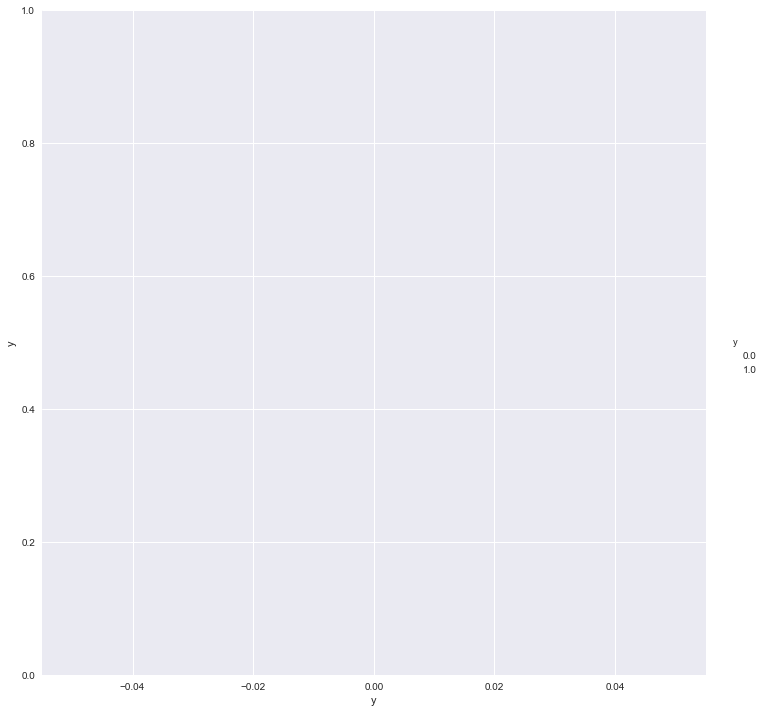

<Figure size 1800x720 with 0 Axes>

/Users/daviddansby/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/daviddansby/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/daviddansby/anaconda/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/daviddansby/anaconda/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/daviddansby/anaconda/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ZeroDivisionError: 0.0 cannot be raised to a negative power

<Figure size 1800x720 with 0 Axes>

In [132]:
for x in range(0, 100, 25):
    plt.figure(figsize=(25,10)) 
    sns.pairplot(pd.concat([df_total[['y']], df_total.iloc[:, 1:x]]), hue='y', height=10)
    plt.show()

In [128]:
# use resample since sns.pairplot slow for data
pp1 = pd.concat([df_total[['y']], df_total.iloc[:, 1:26]])
pp2 = pd.concat([df_total[['y']], df_total.iloc[:, 26:51]])
pp3 = pd.concat([df_total[['y']], df_total.iloc[:, 51:76]])
pp4 = pd.concat([df_total[['y']], df_total.iloc[:, 76:]])

sns.pairplot(pp1, hue='y')
plt.figure(figsize=(25,10)) 
plt.show()

/Users/daviddansby/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


ValueError: Plan shapes are not aligned

In [ ]:
# lets drop total score before moving on to model building 
df_total = df_total.drop(columns=['total_score'])